<a href="https://colab.research.google.com/github/adele9244/Projet_Machine_Learning/blob/main/ProjetMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   **Predicting Residential Property Prices in King County, Washington, Using Supervised Machine Learning**

---



***How can we predict the selling price of a house in Washington State based on its characteristics?***

# **Introduction**

**Business Case :**
Real estate is a dynamic and complex sector, where determining an accurate sale or purchase price is crucial for all stakeholders: buyers, sellers, agents, and financial institutions. King County in Washington, which includes the city of Seattle, is particularly relevant due to its rapid growth and significant market fluctuations.

The main objective of this project is to build a supervised machine learning model to predict the final sale price of a house in this region. This prediction will make it possible to:

- Quickly and objectively assess the market value of a home

- Identify undervalued or overvalued properties, providing a strategic advantage to investors

This project falls squarely within the field of finance/economics or data analysis, and its success will be measured by the accuracy of the price predictions.

# **Step 1 : Preparation and analysis**

- Importing and loading libraries (pandas, numpy, etc.)
- Importing datasets
- Creation of the final dataset

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor

from matplotlib import cm, colors




The dataset **HousePricingData** contains detailed information about 21,613 residential properties, providing a rich foundation for analyzing housing market trends and developing predictive models for real estate prices.

Each observation represents a single property sold, with variables describing its structural characteristics, location, and transaction details.

**General Information**

- id — A unique identifier assigned to each property record
- date — The sale date of the property

**Price Details**
- price — The sale price of the property (target variable). It reflects the market value at the time of sale and serves as the dependent variable in predictive models.

**Property Features**
- bedrooms — Total number of bedrooms in the property.
- bathrooms — Number of bathrooms, including partial bathrooms represented as fractions (e.g., 1.5 for one full and one half bathroom).
- sqft_living — Interior living area measured in square feet, representing the usable floor space inside the home.
- sqft_lot — Total lot area in square feet, including both the building and surrounding land.
- floors — Number of floors (levels) in the building.
- waterfront — Binary indicator specifying whether the property offers a waterfront view (Y/N).
- view — Quality score assessing the view from the property, with higher values indicating more desirable or scenic views.
- condition — Overall condition of the property based on maintenance and preservation (e.g., poor, average, excellent).
- grade — Construction and design quality grade, on a scale typically ranging from 1 to 13 (higher = better materials and finishes).

**Additional Metrics**
- sqft_above — Square footage of the house above ground level, excluding any basement area.
- sqft_basement — Square footage of the basement area, if present.
- yr_built — The year the property was originally constructed.
- yr_renovated — The year of the most recent renovation; 0 or missing values indicate no renovation.

**Location Coordinates**
- zipcode — The ZIP code identifying the property’s geographic area.
- lat — Latitude coordinate of the property location.
- long — Longitude coordinate of the property location.

**Neighbor Comparisons**
- sqft_living15 — Average living area (in square feet) of the 15 nearest neighboring properties, offering a measure of neighborhood housing size.
- sqft_lot15 — Average lot area (in square feet) of the 15 nearest neighboring properties, providing insight into local land use density.

In [52]:
HousePricingData=pd.read_csv('HousePrincingDataset.csv', sep=";")
print(HousePricingData.head())
print(HousePricingData.columns)

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ... grade  sqft_above  sqft_basement  \
0      5650     1.0          N     0  ...     7        1180              0   
1      7242     2.0          N     0  ...     7        2170            400   
2     10000     1.0          N     0  ...     6         770              0   
3      5000     1.0          N     0  ...     7        1050            910   
4      8080     1.0          N     0  ...     8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_liv

We also downloaded the dataset **zipcodes** in order to add the names of the cities from our HousePricingData dataset. This dataset contains the list of all the zipcodes in the US and there city name.

Since different zipcodes can refer to the same city, this added column is going to provide us with a more high level overview of the price variations in different areas.

In [53]:
zipcodes=pd.read_csv('us_zips.csv', sep=";")
print(zipcodes.head())

     zip        city   state state_abbr          county  count_code  latitude  \
0  99553      Akutan  Alaska         AK  Aleutians East          13   54.1430   
1  99571    Cold Bay  Alaska         AK  Aleutians East          13   55.1858   
2  99583  False Pass  Alaska         AK  Aleutians East          13   54.8410   
3  99612   King Cove  Alaska         AK  Aleutians East          13   55.0628   
4  99661  Sand Point  Alaska         AK  Aleutians East          13   55.3192   

   longitude  
0  -165.7854  
1  -162.7211  
2  -163.4368  
3  -162.3056  
4  -160.4914  


In [54]:
zipcodes_for_merge = zipcodes[['zip', 'city']].copy()

data_merged = pd.merge(HousePricingData,zipcodes_for_merge,left_on='zipcode',right_on='zip',how='inner')
data_merged.drop(columns=['zip'], inplace=True)

print("Merged data frame:")
print(data_merged.head())
print("New columns:")
print(data_merged.columns)

Merged data frame:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ... sqft_above  sqft_basement  yr_built  \
0      5650     1.0          N     0  ...       1180              0      1955   
1      7242     2.0          N     0  ...       2170            400      1951   
2     10000     1.0          N     0  ...        770              0      1933   
3      5000     1.0          N     0  ...       1050            910      1965   
4      8080     1.0          N     0  ...       1680              0      1987   

   yr_renovated  zipcode 

For each house sale we calculated the price per sqft it was sold to. We put this value in the column **sqft_price_per_house_calculated**.

In [55]:
data_merged['sqft_price_per_house_calculated']=data_merged['price']/data_merged['sqft_living']
data_merged.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ... sqft_basement  yr_built  \
0      5650     1.0          N     0  ...             0      1955   
1      7242     2.0          N     0  ...           400      1951   
2     10000     1.0          N     0  ...             0      1933   
3      5000     1.0          N     0  ...           910      1965   
4      8080     1.0          N     0  ...             0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0    98178  47.5112 -122.257           1340        5650   
1          1991    98125  47.7210 -122.319           1690        7639   
2             0    98028  47.7379 -122.233           2720        8062   
3             0    98136  47.5208 -122.393           1360        5000   
4             0    98074  47.6168 -122.045           1800        7503   

        city  sqft_price_per_house_calculated  
0    Seattle                       188.050847  
1    Seattle                       209.338521  
2    Kenmore                       233.766234  
3    Seattle                       308.163265  
4  Sammamish                       303.571429  

[5 rows x 23 columns]

For each of the 70 different zipcodes we search the median listing home price per square feet. We used the website https://www.realtor.com/realestateandhomes-search/98117/overview and listed our values in a new file called **HousePrincingDataset_prix.csv**.

This dataset allows us to evaluate if the houses in our initial dataset were sold at prices above or under market prices.

However, these values are prices in 2025, whereas our initial dataset is from 2015. The prices are therefore not yet comparable.


In [56]:
data_price2025=pd.read_csv('HousePrincingDataset_prix.csv', sep=";")
print(data_price2025.head())

   zipcode       City  sqft_price
0    98178    Seattle         401
1    98125    Seattle         486
2    98028    Kenmore         495
3    98136    Seattle         534
4    98074  Sammamish         633


In [57]:
data_price2025.rename(columns={'sqft_price': 'med_sqft_price2025_byzip_online'}, inplace=True)

In [58]:
df_final= pd.merge(data_merged,data_price2025[['zipcode', 'med_sqft_price2025_byzip_online']], left_on='zipcode', right_on='zipcode', how='left')

#Verification
print("Merged data frame :")
print(df_final.head())
print("\nList of columns :")
print(df_final.columns)

Merged data frame :
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ... yr_built  yr_renovated  zipcode  \
0      5650     1.0          N     0  ...     1955             0    98178   
1      7242     2.0          N     0  ...     1951          1991    98125   
2     10000     1.0          N     0  ...     1933             0    98028   
3      5000     1.0          N     0  ...     1965             0    98136   
4      8080     1.0          N     0  ...     1987             0    98074   

       lat     long  sqft_living15  sqft_lot15  

In [59]:
med_sqft_price2015_byzip_calculated=df_final.groupby('zipcode')['sqft_price_per_house_calculated'].median().reset_index()

med_sqft_price2015_byzip_calculated.rename(
    columns={'sqft_price_per_house_calculated': 'med_sqft_price2015_byzip_calculated'},
    inplace=True
)
df_final = pd.merge(df_final, med_sqft_price2015_byzip_calculated, on='zipcode', how='left')


print("New columns :")
print(df_final.columns)
print(df_final.head())

New columns :
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'city',
       'sqft_price_per_house_calculated', 'med_sqft_price2025_byzip_online',
       'med_sqft_price2015_byzip_calculated'],
      dtype='object')
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ... yr_renovated  zipcode      lat  \
0      5650   

According to the Federal Reserve Bank of St Louis (https://fred.stlouisfed.org/series/ATNHPIUS53033A), the average house sale price in King County, Washington, was multiplied by 1.989 between 2015 and 2025.

In order to know the median price/sqft of each zipcode in 2015, we divide the value we have for 2025 by 1.989.

In [60]:
df_final['med_sqft_price2015_byzip_online']=df_final['med_sqft_price2025_byzip_online']/1.989
print(df_final.head())

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ... zipcode      lat     long  \
0      5650     1.0          N     0  ...   98178  47.5112 -122.257   
1      7242     2.0          N     0  ...   98125  47.7210 -122.319   
2     10000     1.0          N     0  ...   98028  47.7379 -122.233   
3      5000     1.0          N     0  ...   98136  47.5208 -122.393   
4      8080     1.0          N     0  ...   98074  47.6168 -122.045   

   sqft_living15  sqft_lot15       city  sqft_price_per_house_calculated  \
0           1340        5650

# **Step 2 : Data Pre-processing:**
- Management of outliers (aberrant values).

- Encoding of categorical variables (e.g., waterfront, postcode).

- Scaling of numerical variables (e.g., sqft_living).

- Separation into training/test sets (train-test split).

We transform our categorical variables into numerical ones in order to be able to apply different formulas and algorithms.
- For **waterfront** if there is, it's 1 if there is none, it's 0.
- For **condition**, it goes from poor (1) to very good (5).

We therefore add the columns  conditions_num and waterfront_num for the numerical values.


In [61]:
unique_values_condition = df_final['condition'].unique()
print(unique_values_condition)

['Average' 'Very Good' 'Good' 'Poor' 'Fair']


After adding all the columns we need, we extract the data into a new csv file.


In [62]:
condition_mapping = {
    'Poor': 1,
    'Fair': 2,
    'Average': 3,
    'Good': 4,
    'Very Good': 5
}

df_final['condition_num'] = df_final['condition'].replace(condition_mapping)

print(df_final[['condition', 'condition_num']].head())

   condition  condition_num
0    Average              3
1    Average              3
2    Average              3
3  Very Good              5
4    Average              3


/tmp/ipython-input-469834150.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['condition_num'] = df_final['condition'].replace(condition_mapping)


In [63]:
waterfront_mapping = {
    'N': 0,
    'Y': 1
}

df_final['waterfront_num'] = df_final['waterfront'].replace(waterfront_mapping)
df_final['waterfront_num'] = df_final['waterfront_num'].astype('int64')

print(df_final[['waterfront', 'waterfront_num']].head())

  waterfront  waterfront_num
0          N               0
1          N               0
2          N               0
3          N               0
4          N               0


/tmp/ipython-input-2876640381.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['waterfront_num'] = df_final['waterfront'].replace(waterfront_mapping)


In [64]:
output_filename = 'KingCounty_HousePricing_with_ZipMedian.csv'

try:
    df_final.to_csv(
        output_filename,
        index=False,
        sep=';'
    )
    print(f"Data frame was successfully saved in file : {output_filename}")

except Exception as e:
    print(f"Error whil saving file : {e}")

Data frame was successfully saved in file : KingCounty_HousePricing_with_ZipMedian.csv


In [65]:
df = df_final.copy()

In [66]:
print(f"Number of duplicates : {df.duplicated().sum()}")

print(f"Number of missing values per column :")
print(df.isnull().sum())

Number of duplicates : 0
Number of missing values per column :
id                                     0
date                                   0
price                                  0
bedrooms                               0
bathrooms                              0
sqft_living                            0
sqft_lot                               0
floors                                 0
waterfront                             0
view                                   0
condition                              0
grade                                  0
sqft_above                             0
sqft_basement                          0
yr_built                               0
yr_renovated                           0
zipcode                                0
lat                                    0
long                                   0
sqft_living15                          0
sqft_lot15                             0
city                                   0
sqft_price_per_house_calculated    

There are no duplicates or missing values, our dataset is ready.

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   21613 non-null  int64  
 1   date                                 21613 non-null  object 
 2   price                                21613 non-null  float64
 3   bedrooms                             21613 non-null  int64  
 4   bathrooms                            21613 non-null  float64
 5   sqft_living                          21613 non-null  int64  
 6   sqft_lot                             21613 non-null  int64  
 7   floors                               21613 non-null  float64
 8   waterfront                           21613 non-null  object 
 9   view                                 21613 non-null  int64  
 10  condition                            21613 non-null  object 
 11  grade                       

The only variable that is not numerical is the city name, so we don't need to modify any variable type.

In [68]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors          view         grade    sqft_above  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.234303      7.656873   1788.390691   
std    4.142051e+04      0.539989      0.766318      1.175459    828.090978   
min    5.200000e+02      1.000000      0.000000      1.000000    290.000000   
25%    5.040000e+03      1.000000      0.000000      7.000000   1190.000000   
50%    7.618000e+03      1.500000      0.000000      7.000000   1560.000000   
75%    1.068800e+04      2.000000      0.000000      8.000000   2210.000000   
max    1.651359e+06      3.500000      4.000000     13.000000   9410.000000   

       ...           lat          long  sqft_living15     sqft_lot15  \
count  ...  21613.000000  21613.000000   21613.000000   21613.000000   
mean   ...     47.560053   -122.213896    1986.552492   12768.455652   
std    ...      0.138564      0.140828     685.391304   27304.179631   
min    ...     47.155900   -122.519000     399.000000     651.000000   
25%    ...     47.471000   -122.328000    1490.000000    5100.000000   
50%    ...     47.571800   -122.230000    1840.000000    7620.000000   
75%    ...     47.678000   -122.125000    2360.000000   10083.000000   
max    ...     47.777600   -121.315000    6210.000000  871200.000000   

       sqft_price_per_house_calculated  med_sqft_price2025_byzip_online  \
count                     21613.000000                     21613.000000   
mean                        264.156594                       510.972887   
std                         110.060793                       140.630770   
min                          87.588235                       314.000000   
25%                         182.291667                       401.000000   
50%                         244.644550                       500.000000   
75%                         318.322981                       599.000000   
max                         810.138889                      1500.000000   

       med_sqft_price2015_byzip_calculated  med_sqft_price2015_byzip_online  \
count                         21613.000000                     21613.000000   
mean                            253.737582                       256.899390   
std                              78.941787                        70.704259   
min                             144.970414                       157.868276   
25%                             181.422925                       201.608849   
50%                             250.824176                       251.382604   
75%                             302.631579                       301.156360   
max                             565.165614                       754.147813   

       condition_num  waterfront_num  
count   21613.000000    21613.000000  
mean        3.409430        0.007542  
std         0.650743        0.086517  
min         1.000000        0.000000  
25%         3.000000        0.000000  
50%         3.000000        0.000000  
75%         4.000000        0.000000  
max         5.000000        1.000000  

[8 rows x 24 columns]

In [69]:
print("\nQuick Check of our dataset")

print(f"Price :")
print(f"Average : ${df['price'].mean():,.0f}")
print(f"Median : ${df['price'].median():,.0f}")
print(f"Min : ${df['price'].min():,.0f}")
print(f"Max : ${df['price'].max():,.0f}")

print(f"\nLiving space :")
print(f"Average : {df['sqft_living'].mean():.0f} sqft")
print(f"Median : {df['sqft_living'].median():.0f} sqft")

print(f"\nAverage characteristics :")
print(f"Rooms : {df['bedrooms'].mean():.1f}")
print(f"bathroom : {df['bathrooms'].mean():.1f}")
print(f"floors : {df['floors'].mean():.1f}")

print(f"\nSquarefeet price :")
print(f"Average : ${df['sqft_price_per_house_calculated'].mean():.0f}")
print(f"Median : ${df['sqft_price_per_house_calculated'].median():.0f}")

print(f"\nConstruction year:")
print(f"Oldest : {df['yr_built'].min()}")
print(f"Earliest : {df['yr_built'].max()}")
print(f"Average : {df['yr_built'].mean():.0f}")

print(f"\nWaterfront view:")
print(df['waterfront_num'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

print(f"\nView:")
print(f"Average view quality : {df['view'].mean():.2f} /4")

print(f"\nGrade:")
print(f"Average grade : {df['grade'].mean():.2f} /13")



Quick Check of our dataset
Price :
Average : $540,088
Median : $450,000
Min : $75,000
Max : $7,700,000

Living space :
Average : 2080 sqft
Median : 1910 sqft

Average characteristics :
Rooms : 3.4
bathroom : 2.1
floors : 1.5

Squarefeet price :
Average : $264
Median : $245

Construction year:
Oldest : 1900
Earliest : 2015
Average : 1971

Waterfront view:
waterfront_num
0    99.2%
1     0.8%
Name: proportion, dtype: object

View:
Average view quality : 0.23 /4

Grade:
Average grade : 7.66 /13


# **Step 3:Analysis**

- Exploratory Data Analysis (EDA):

- Checking the number of rows and columns, and the type of variables.

- Analysis of the distribution of the target : Price

- Correlation analysis (e.g., correlation between sqft_living and price).
- Analyse the imbalance issue in our dataset (lab4)



In [70]:
df.shape

(21613, 28)

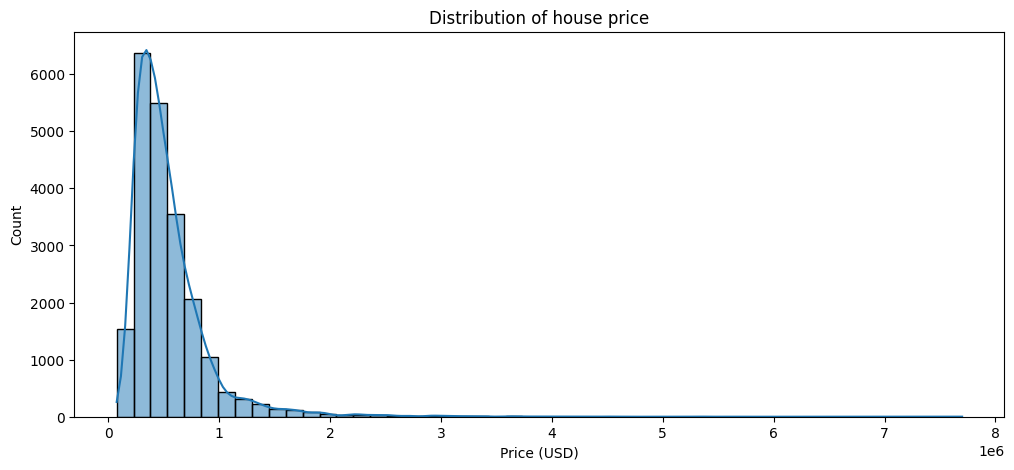

In [71]:
plt.figure(figsize=(12, 5))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of house price')
plt.xlabel('Price (USD)')
plt.show()

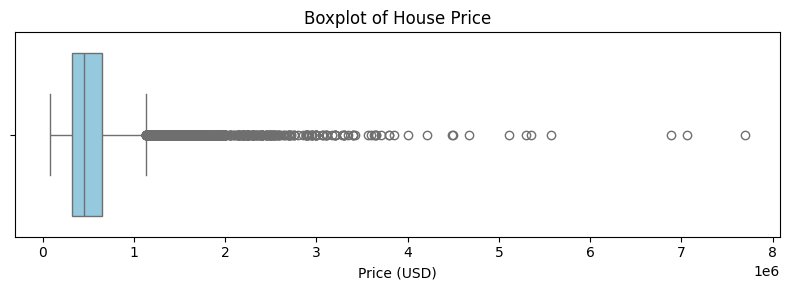

In [72]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=df['price'], color='skyblue')
plt.title('Boxplot of House Price')
plt.xlabel('Price (USD)')
plt.tight_layout()
plt.show()

In [73]:
print(f"Median price : {df['price'].median():.0f}")
print(f"Minimum price : {df['price'].min():.0f}")
print(f"Maximum price : {df['price'].max():.0f}")
print(f"Average price : {df['price'].mean():.0f}")


Median price : 450000
Minimum price : 75000
Maximum price : 7700000
Average price : 540088


In [74]:
df_expensive_houses = df[df['price'] > 1_500_000].copy()
print(f"Number of houses with price > $1.5M: {df_expensive_houses.shape[0]}")
df_expensive_houses.head()

Number of houses with price > $1.5M: 516


id             date      price  bedrooms  bathrooms  sqft_living  \
21   2524049179  20140826T000000  2000000.0         3       2.75         3050   
153  7855801670  20150401T000000  2250000.0         4       3.25         5180   
216    46100204  20150221T000000  1505000.0         5       3.00         3300   
246  2025069065  20140929T000000  2400000.0         4       2.50         3650   
269  7960900060  20150504T000000  2900000.0         4       3.25         5050   

     sqft_lot  floors waterfront  view  ...     long  sqft_living15  \
21      44867     1.0          N     4  ... -122.233           4110   
153     19850     2.0          N     3  ... -122.162           3160   
216     33474     1.0          N     3  ... -122.210           3836   
246      8354     1.0          Y     4  ... -122.072           3120   
269     20100     1.5          N     2  ... -122.223           3890   

     sqft_lot15           city  sqft_price_per_house_calculated  \
21        20336  Mercer Island                       655.737705   
153        9750       Bellevue                       434.362934   
216       20953  Mercer Island                       456.060606   
246       18841      Sammamish                       657.534247   
269       20060       Bellevue                       574.257426   

     med_sqft_price2025_byzip_online  med_sqft_price2015_byzip_calculated  \
21                               824                           376.370822   
153                              640                           288.232917   
216                              824                           376.370822   
246                              633                           255.351682   
269                              955                           456.944444   

     med_sqft_price2015_byzip_online  condition_num  waterfront_num  
21                        414.278532              3               0  
153                       321.769734              3               0  
216                       414.278532              3               0  
246                       318.250377              3               1  
269                       480.140774              3               0  

[5 rows x 28 columns]

In [75]:
df_not_expensive_houses = df[df['price'] <= 1_500_000].copy()
print(f"Number of houses with price <= $1.5M: {df_not_expensive_houses.shape[0]}")
df_not_expensive_houses.head()

Number of houses with price <= $1.5M: 21097


id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...     long  sqft_living15  sqft_lot15  \
0      5650     1.0          N     0  ... -122.257           1340        5650   
1      7242     2.0          N     0  ... -122.319           1690        7639   
2     10000     1.0          N     0  ... -122.233           2720        8062   
3      5000     1.0          N     0  ... -122.393           1360        5000   
4      8080     1.0          N     0  ... -122.045           1800        7503   

        city  sqft_price_per_house_calculated  \
0    Seattle                       188.050847   
1    Seattle                       209.338521   
2    Kenmore                       233.766234   
3    Seattle                       308.163265   
4  Sammamish                       303.571429   

   med_sqft_price2025_byzip_online  med_sqft_price2015_byzip_calculated  \
0                              401                           176.623459   
1                              486                           263.980288   
2                              495                           221.854305   
3                              534                           319.444444   
4                              633                           255.351682   

   med_sqft_price2015_byzip_online  condition_num  waterfront_num  
0                       201.608849              3               0  
1                       244.343891              3               0  
2                       248.868778              3               0  
3                       268.476621              5               0  
4                       318.250377              3               0  

[5 rows x 28 columns]

In [76]:
df_expensive_houses.describe()

id         price    bedrooms   bathrooms   sqft_living  \
count  5.160000e+02  5.160000e+02  516.000000  516.000000    516.000000   
mean   4.087059e+09  2.126877e+06    4.218992    3.519864   4439.434109   
std    2.744043e+09  7.399981e+05    0.918265    0.941991   1347.293706   
min    4.610020e+07  1.505000e+06    2.000000    1.750000   2190.000000   
25%    1.801260e+09  1.661500e+06    4.000000    2.750000   3530.000000   
50%    3.624275e+09  1.880790e+06    4.000000    3.500000   4250.000000   
75%    6.065300e+09  2.350490e+06    5.000000    4.000000   5040.000000   
max    9.831200e+09  7.700000e+06    8.000000    8.000000  13540.000000   

            sqft_lot      floors        view       grade   sqft_above  ...  \
count     516.000000  516.000000  516.000000  516.000000   516.000000  ...   
mean    29996.823643    1.862403    1.633721   10.312016  3622.232558  ...   
std     80002.500494    0.484178    1.666211    1.168158  1235.619243  ...   
min      1880.000000    1.000000    0.000000    7.000000  1450.000000  ...   
25%      8540.000000    2.000000    0.000000   10.000000  2660.000000  ...   
50%     14009.500000    2.000000    1.000000   10.000000  3482.500000  ...   
75%     20770.500000    2.000000    3.000000   11.000000  4302.500000  ...   
max    920423.000000    3.500000    4.000000   13.000000  9410.000000  ...   

              lat        long  sqft_living15     sqft_lot15  \
count  516.000000  516.000000     516.000000     516.000000   
mean    47.617326 -122.225421    3317.110465   21473.649225   
std      0.053291    0.096875     824.377843   48916.360637   
min     47.416900 -122.416000    1280.000000    2199.000000   
25%     47.580800 -122.283000    2777.500000    8525.750000   
50%     47.624950 -122.224000    3260.000000   12910.500000   
75%     47.640675 -122.201000    3831.500000   19281.000000   
max     47.766600 -121.756000    6210.000000  858132.000000   

       sqft_price_per_house_calculated  med_sqft_price2025_byzip_online  \
count                       516.000000                       516.000000   
mean                        494.278415                       770.726744   
std                         126.673924                       251.494425   
min                         168.389956                       401.000000   
25%                         408.968719                       582.500000   
50%                         474.753345                       699.000000   
75%                         581.268377                       955.000000   
max                         800.000000                      1500.000000   

       med_sqft_price2015_byzip_calculated  med_sqft_price2015_byzip_online  \
count                           516.000000                       516.000000   
mean                            375.277492                       387.494592   
std                              90.518607                       126.442647   
min                             176.623459                       201.608849   
25%                             291.935484                       292.860734   
50%                             376.370822                       351.432881   
75%                             456.944444                       480.140774   
max                             565.165614                       754.147813   

       condition_num  waterfront_num  
count     516.000000      516.000000  
mean        3.509690        0.153101  
std         0.725341        0.360434  
min         2.000000        0.000000  
25%         3.000000        0.000000  
50%         3.000000        0.000000  
75%         4.000000        0.000000  
max         5.000000        1.000000  

[8 rows x 24 columns]

In [77]:
df_not_expensive_houses.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.109700e+04  2.109700e+04  21097.000000  21097.000000  21097.000000   
mean   4.592365e+09  5.012777e+05      3.350097      2.080391   2022.189174   
std    2.878734e+09  2.482295e+05      0.920632      0.732479    824.830866   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.125059e+09  3.199500e+05      3.000000      1.500000   1410.000000   
50%    3.905040e+09  4.450000e+05      3.000000      2.250000   1890.000000   
75%    7.334501e+09  6.250000e+05      4.000000      2.500000   2500.000000   
max    9.900000e+09  1.500000e+06     33.000000      7.500000   7480.000000   

           sqft_lot        floors          view         grade    sqft_above  \
count  2.109700e+04  21097.000000  21097.000000  21097.000000  21097.000000   
mean   1.474278e+04      1.485306      0.200076      7.591933   1743.537754   
std    3.994771e+04      0.538147      0.696247      1.097968    762.211936   
min    5.200000e+02      1.000000      0.000000      1.000000    290.000000   
25%    5.001000e+03      1.000000      0.000000      7.000000   1180.000000   
50%    7.552000e+03      1.000000      0.000000      7.000000   1540.000000   
75%    1.045400e+04      2.000000      0.000000      8.000000   2160.000000   
max    1.651359e+06      3.500000      4.000000     12.000000   7320.000000   

       ...           lat          long  sqft_living15     sqft_lot15  \
count  ...  21097.000000  21097.000000   21097.000000   21097.000000   
mean   ...     47.558652   -122.213615    1954.009101   12555.540077   
std    ...      0.139707      0.141723     648.304608   26522.455164   
min    ...     47.155900   -122.519000     399.000000     651.000000   
25%    ...     47.465900   -122.330000    1480.000000    5078.000000   
50%    ...     47.569400   -122.231000    1820.000000    7565.000000   
75%    ...     47.678900   -122.123000    2320.000000    9994.000000   
max    ...     47.777600   -121.315000    5790.000000  871200.000000   

       sqft_price_per_house_calculated  med_sqft_price2025_byzip_online  \
count                     21097.000000                     21097.000000   
mean                        258.528170                       504.619709   
std                         103.397177                       130.483667   
min                          87.588235                       314.000000   
25%                         180.851064                       396.000000   
50%                         241.843972                       500.000000   
75%                         311.985816                       583.000000   
max                         810.138889                      1500.000000   

       med_sqft_price2015_byzip_calculated  med_sqft_price2015_byzip_online  \
count                         21097.000000                     21097.000000   
mean                            250.764904                       253.705233   
std                              76.249954                        65.602648   
min                             144.970414                       157.868276   
25%                             176.623459                       199.095023   
50%                             245.212571                       251.382604   
75%                             302.631579                       293.112117   
max                             565.165614                       754.147813   

       condition_num  waterfront_num  
count   21097.000000    21097.000000  
mean        3.406977        0.003982  
std         0.648636        0.062976  
min         1.000000        0.000000  
25%         3.000000        0.000000  
50%         3.000000        0.000000  
75%         4.000000        0.000000  
max         5.000000        1.000000  

[8 rows x 24 columns]

The distribution and boxplot of house prices clearly show that the variable is strongly **right-skewed**, meaning most properties are sold at relatively moderate prices, while a small number of very expensive homes significantly raise the upper tail of the distribution. The histogram indicates that the majority of sales are concentrated below one million dollars, with a steep decline in frequency as price increases. This pattern is confirmed by the boxplot, where the box (representing the interquartile range) is compressed near the lower end of the scale, and numerous outliers extend far to the right, reaching prices up to seven million dollars.

Although the **average price is 540,088 dollars**, this value does not reflect the typical property in the dataset because it is heavily influenced by these few high-value outliers. The **median price is 450,000 dollars**, providing a more representative measure of the “typical” home value. Overall, these graphs highlight a highly unequal price distribution within the housing market, where a minority of luxury properties drive up the mean while most houses remain within a much narrower and lower price range.

The comparison between houses sold for more than 1,5 million dollars and those sold for less than 1,5 million highlights clear structural and qualitative differences.

Expensive houses are, on average, three times larger in living area (around 4,400 sqft versus 2,000 sqft) and have higher overall grades (10.3 compared to 7.6). They also feature twice as much bathrooms and slightly more bedrooms, confirming that both size and interior quality play a major role in price escalation.
These high-end properties often have larger lots and better views, with about 15 % located near the waterfront, while almost none (0,4%) of the lower-priced homes have such amenities.

Interestingly, some factors such as the overall condition of the house and number of floors do not vary dramatically between the two groups, suggesting that beyond a certain threshold, these characteristics have limited impact on price.

Overall, the strongest drivers of very high prices are living space, construction quality, and premium location features (especially waterfront and view), while general condition or floor count have relatively minor influence.

There are only 516 houses sold for over 1.5M vs 21097 solv for under 1.5M. Therefore we consider that these houses are not representative, and we think the high prices also depend a lot on features we don't have in our dataset, such as having a pool, a fountain, a terrasse, high end materials, an indoor cinema etc.

Since we don't have more information on why thoses houses were so expensive, we are going to get rid of the 516 houses sold over 1.5 million to avoid disrupting our training


In [78]:
df = df[df['price'] <= 1_500_000].copy()

In [79]:
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...     long  sqft_living15  sqft_lot15  \
0      5650     1.0          N     0  ... -122.257           1340        5650   
1      7242     2.0          N     0  ... -122.319           1690        7639   
2     10000     1.0          N     0  ... -122.233           2720        8062   
3      5000     1.0          N     0  ... -122.393           1360        5000   
4      8080     1.0          N     0  ... -122.045           1800        7503   

        city  sqft_price_per_house_calculated  \
0    Seattle                       188.050847   
1    Seattle                       209.338521   
2    Kenmore                       233.766234   
3    Seattle                       308.163265   
4  Sammamish                       303.571429   

   med_sqft_price2025_byzip_online  med_sqft_price2015_byzip_calculated  \
0                              401                           176.623459   
1                              486                           263.980288   
2                              495                           221.854305   
3                              534                           319.444444   
4                              633                           255.351682   

   med_sqft_price2015_byzip_online  condition_num  waterfront_num  
0                       201.608849              3               0  
1                       244.343891              3               0  
2                       248.868778              3               0  
3                       268.476621              5               0  
4                       318.250377              3               0  

[5 rows x 28 columns]

In [80]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.109700e+04  2.109700e+04  21097.000000  21097.000000  21097.000000   
mean   4.592365e+09  5.012777e+05      3.350097      2.080391   2022.189174   
std    2.878734e+09  2.482295e+05      0.920632      0.732479    824.830866   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.125059e+09  3.199500e+05      3.000000      1.500000   1410.000000   
50%    3.905040e+09  4.450000e+05      3.000000      2.250000   1890.000000   
75%    7.334501e+09  6.250000e+05      4.000000      2.500000   2500.000000   
max    9.900000e+09  1.500000e+06     33.000000      7.500000   7480.000000   

           sqft_lot        floors          view         grade    sqft_above  \
count  2.109700e+04  21097.000000  21097.000000  21097.000000  21097.000000   
mean   1.474278e+04      1.485306      0.200076      7.591933   1743.537754   
std    3.994771e+04      0.538147      0.696247      1.097968    762.211936   
min    5.200000e+02      1.000000      0.000000      1.000000    290.000000   
25%    5.001000e+03      1.000000      0.000000      7.000000   1180.000000   
50%    7.552000e+03      1.000000      0.000000      7.000000   1540.000000   
75%    1.045400e+04      2.000000      0.000000      8.000000   2160.000000   
max    1.651359e+06      3.500000      4.000000     12.000000   7320.000000   

       ...           lat          long  sqft_living15     sqft_lot15  \
count  ...  21097.000000  21097.000000   21097.000000   21097.000000   
mean   ...     47.558652   -122.213615    1954.009101   12555.540077   
std    ...      0.139707      0.141723     648.304608   26522.455164   
min    ...     47.155900   -122.519000     399.000000     651.000000   
25%    ...     47.465900   -122.330000    1480.000000    5078.000000   
50%    ...     47.569400   -122.231000    1820.000000    7565.000000   
75%    ...     47.678900   -122.123000    2320.000000    9994.000000   
max    ...     47.777600   -121.315000    5790.000000  871200.000000   

       sqft_price_per_house_calculated  med_sqft_price2025_byzip_online  \
count                     21097.000000                     21097.000000   
mean                        258.528170                       504.619709   
std                         103.397177                       130.483667   
min                          87.588235                       314.000000   
25%                         180.851064                       396.000000   
50%                         241.843972                       500.000000   
75%                         311.985816                       583.000000   
max                         810.138889                      1500.000000   

       med_sqft_price2015_byzip_calculated  med_sqft_price2015_byzip_online  \
count                         21097.000000                     21097.000000   
mean                            250.764904                       253.705233   
std                              76.249954                        65.602648   
min                             144.970414                       157.868276   
25%                             176.623459                       199.095023   
50%                             245.212571                       251.382604   
75%                             302.631579                       293.112117   
max                             565.165614                       754.147813   

       condition_num  waterfront_num  
count   21097.000000    21097.000000  
mean        3.406977        0.003982  
std         0.648636        0.062976  
min         1.000000        0.000000  
25%         3.000000        0.000000  
50%         3.000000        0.000000  
75%         4.000000        0.000000  
max         5.000000        1.000000  

[8 rows x 24 columns]

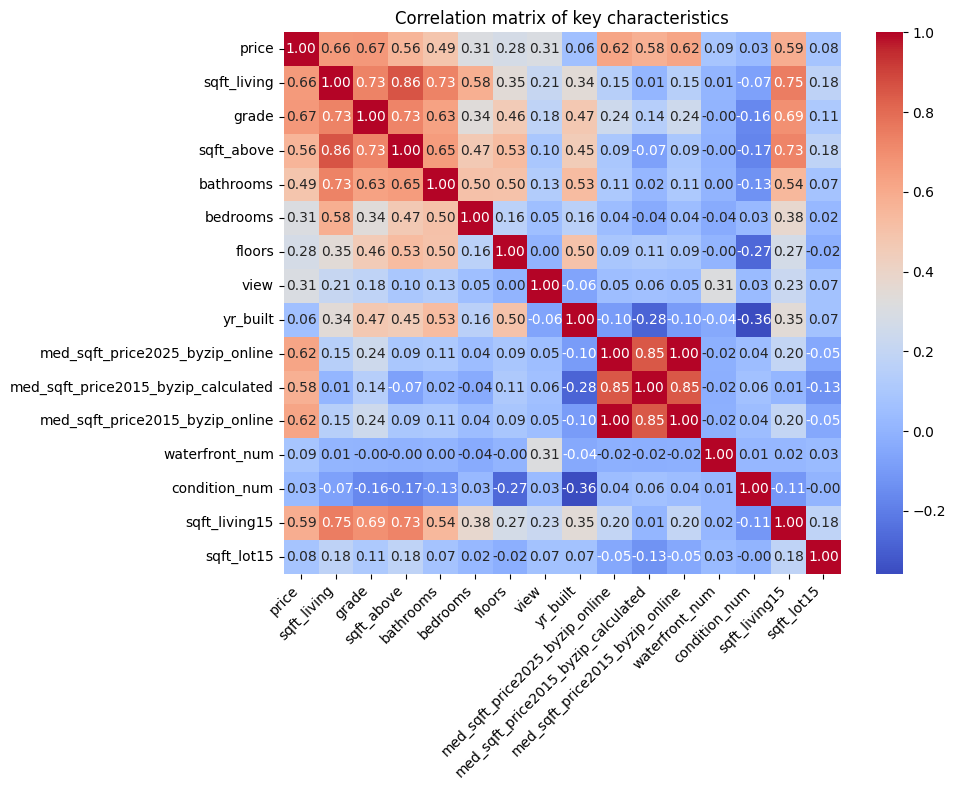

In [81]:
numeric_cols_for_corr = [
    'price',
    'sqft_living',
    'grade',
    'sqft_above',
    'bathrooms',
    'bedrooms',
    'floors',
    'view',
    'yr_built',
    'med_sqft_price2025_byzip_online',
    'med_sqft_price2015_byzip_calculated',
    'med_sqft_price2015_byzip_online',
    'waterfront_num',
    'condition_num',
    'sqft_living15',
    'sqft_lot15',
]


correlation_matrix = df[numeric_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar=True
)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation matrix of key characteristics')
plt.tight_layout()
plt.show()

The **correlation matrix** reveals that a few key variables dominate the relationship with house **prices**. The living space area (**sqft_living**) shows the strongest positive correlation with price, indicating that larger houses tend to sell for significantly higher values. This relationship is reinforced by **grade**, which captures the overall quality of construction and design, and by **sqft_above**, representing the above-ground living area—both are strongly associated with higher prices. These three features move closely together, reflecting that better quality homes are generally larger and therefore more expensive.

Other influential variables include the number of **bathrooms** and the average size of neighboring properties (**sqft_living15**), both showing moderate positive correlations. This suggests that not only the size and quality of a house but also the general characteristics of nearby homes contribute to its market value. In contrast, variables such as **condition, floors**, and **year built** display weak correlations, indicating that they alone do not explain much of the variation in price.

A particularly notable pattern appears among the **zipcode-based median price features** (med_sqft_price2015_byzip_online, med_sqft_price2015_byzip_calculated, and med_sqft_price2025_byzip_online), which are extremely correlated with each other and also show strong associations with price. These features capture the influence of location and local market conditions, but they may also introduce redundancy or potential data leakage if not handled carefully. Overall, the correlations highlight that **size, quality, and location are the most decisive factors** driving house prices, while many structural attributes contribute only marginally.

Across the other features, two tight correlation clusters stand out. First is the size/quality cluster: **sqft_living, sqft_above, bathrooms, grade**, and to a lesser extent **sqft_living15** move strongly together. Larger homes tend to devote more area above ground, include more bathrooms, and receive higher construction/design grades; neighborhoods with larger average homes (**sqft_living15**) reinforce this pattern.

A secondary but important cluster is the location-price group: the **three zipcode-level median price-per-sqft features**(med_sqft_price2015_byzip_online, med_sqft_price2015_byzip_calculated, med_sqft_price2025_byzip_online) are extremely correlated with each other because they encode essentially the same market signal at slightly different sources/times.

Outside these clusters, **most other pairwise relationships are modest**, with bedrooms largely riding on overall size rather than adding distinct signal, and variables like yr_built, floors, and condition_num showing weaker, less collinear structure that likely manifests through non-linear effects rather than strong linear ties.

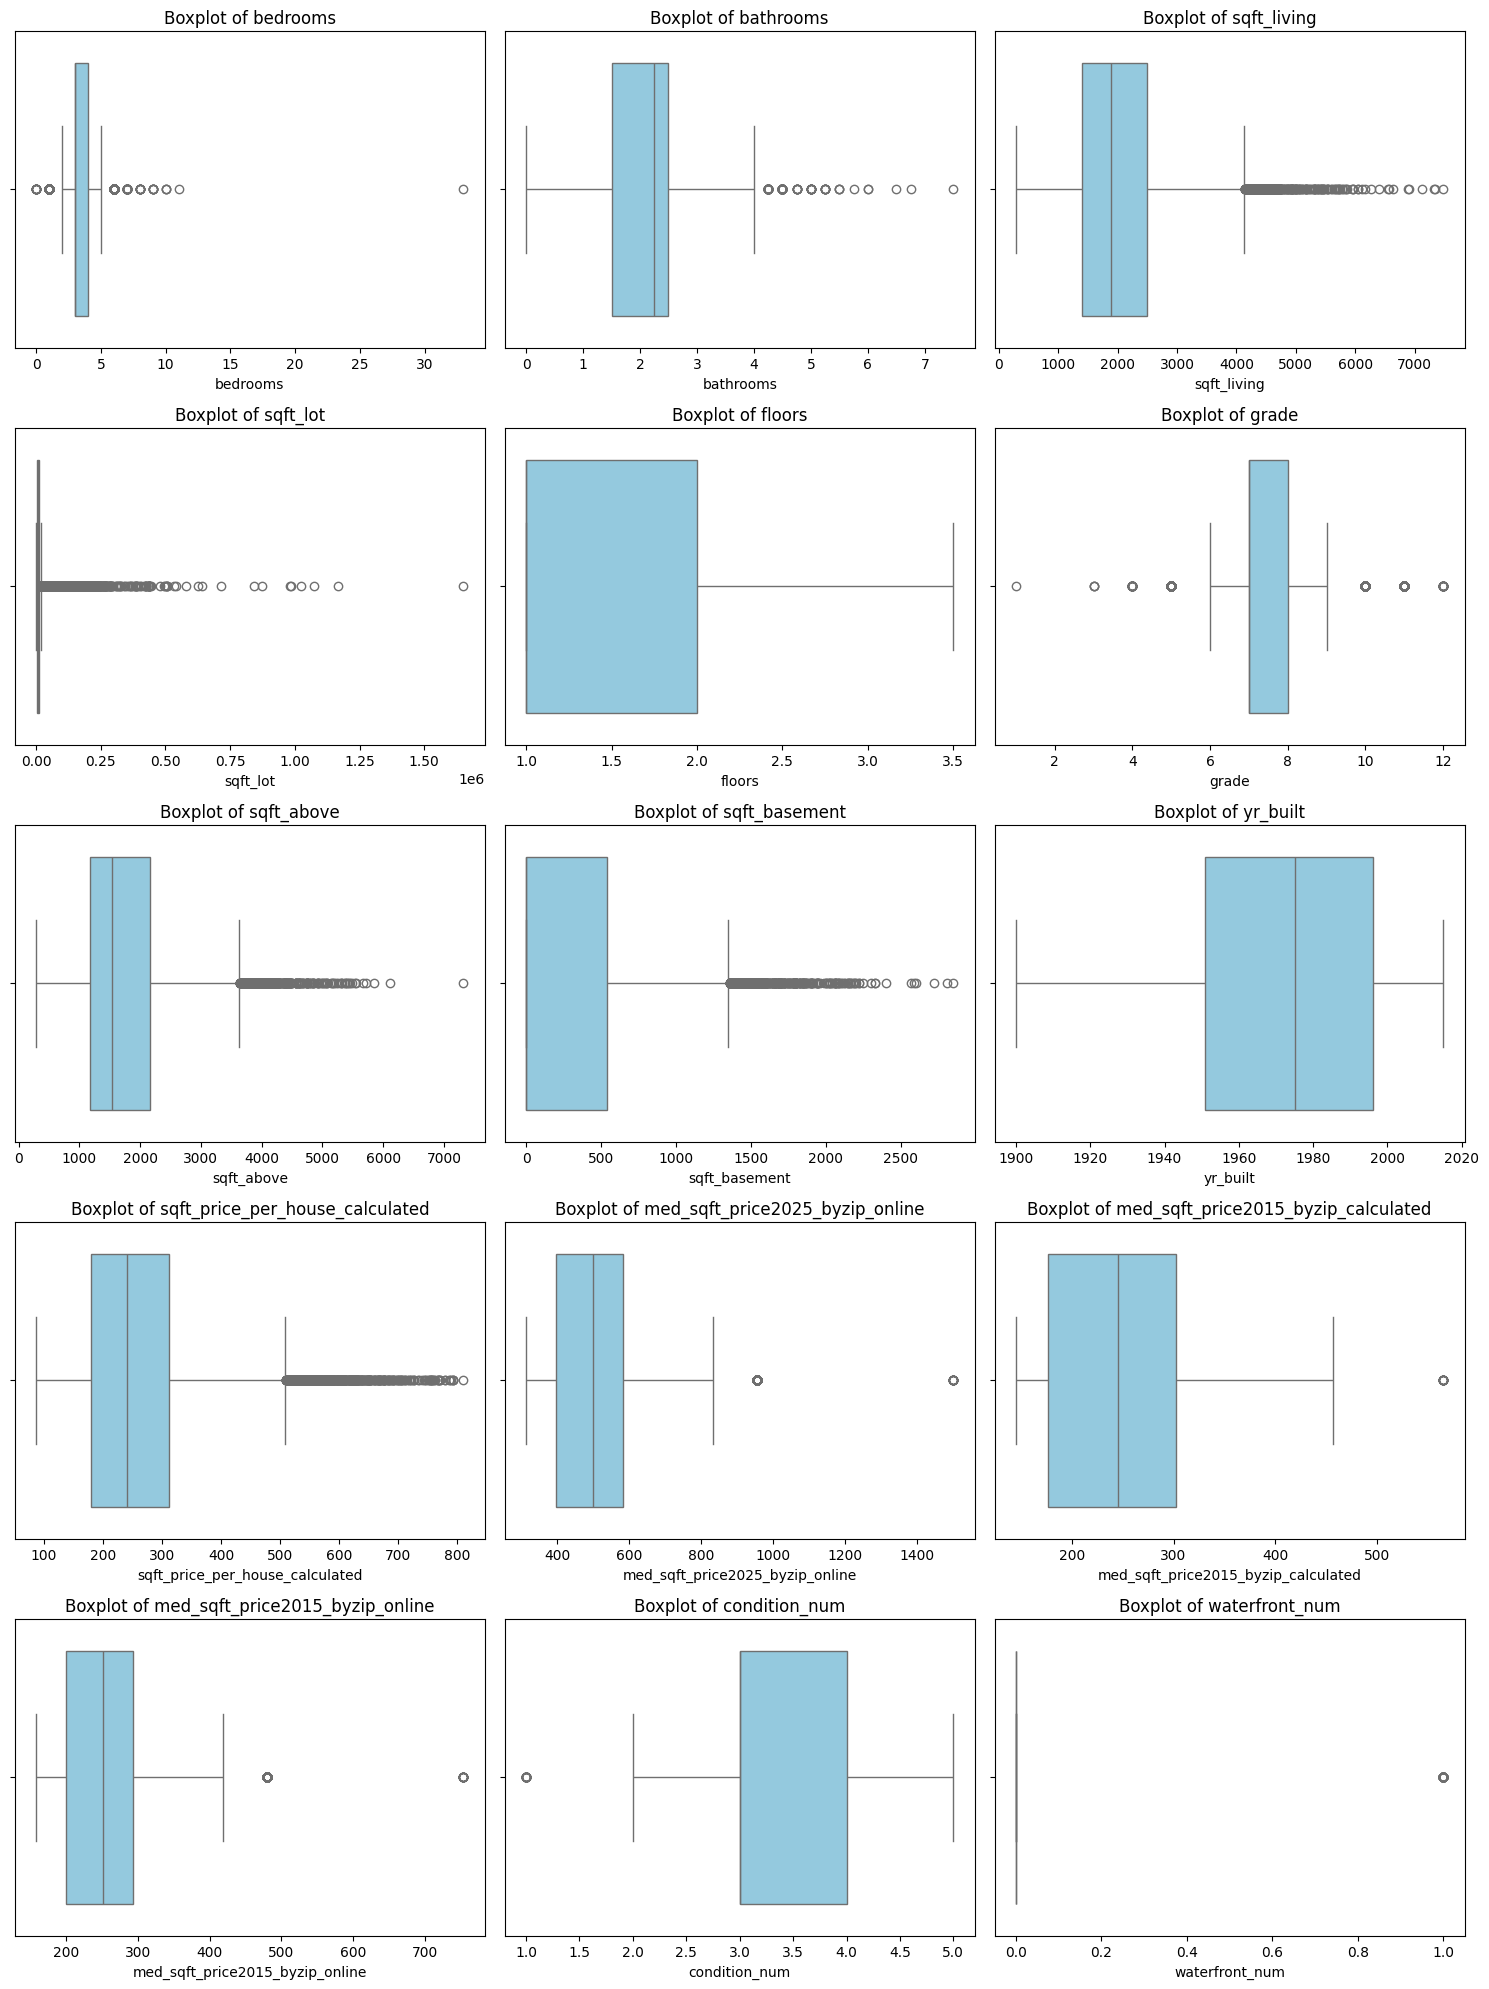

In [82]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

cols_to_plot = [
    col for col in numeric_cols
    if col not in ['id','price','zipcode','sqft_lot15',
                   'sqft_living15','long','lat','yr_renovated','view']
]

n=len(cols_to_plot)

cols = 3
rows= int(np.ceil(n / cols))

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

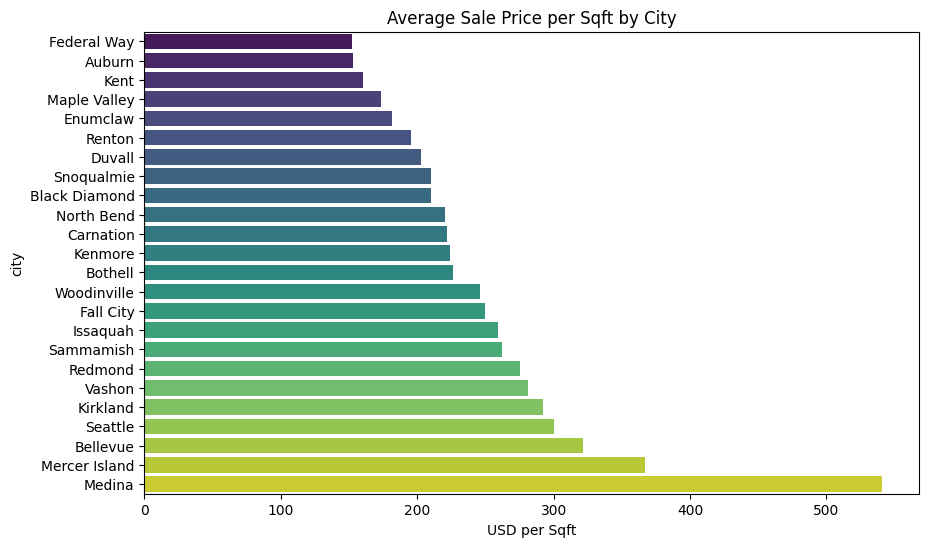

In [83]:
# in this graph the price value is the actual one of the sale. It was calculated by dividing the price by the surface.
#The houses were actually sold at those prices

avg_price_sqft_city = (df.groupby('city')['sqft_price_per_house_calculated']
      .mean()
      .sort_values(ascending=True))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=avg_price_sqft_city.values,
    y=avg_price_sqft_city.index,
    hue=avg_price_sqft_city.index,
    palette='viridis')

plt.title('Average Sale Price per Sqft by City')
plt.xlabel('USD per Sqft')
plt.show()

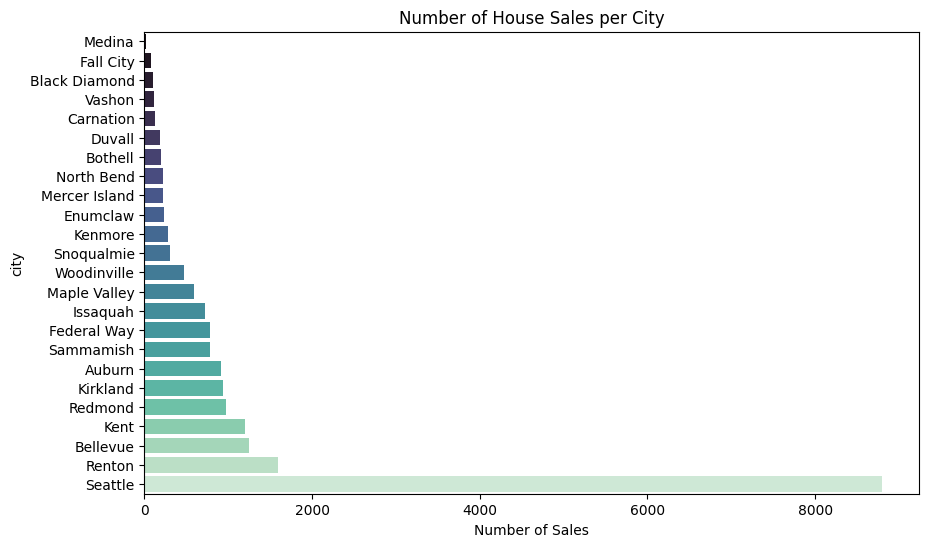

In [84]:
sales_per_city = (df['city']
    .value_counts()
    .sort_values(ascending=True))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=sales_per_city.values,
    y=sales_per_city.index,
    hue=sales_per_city.index,
    palette='mako')

plt.title('Number of House Sales per City')
plt.xlabel('Number of Sales')
plt.show()

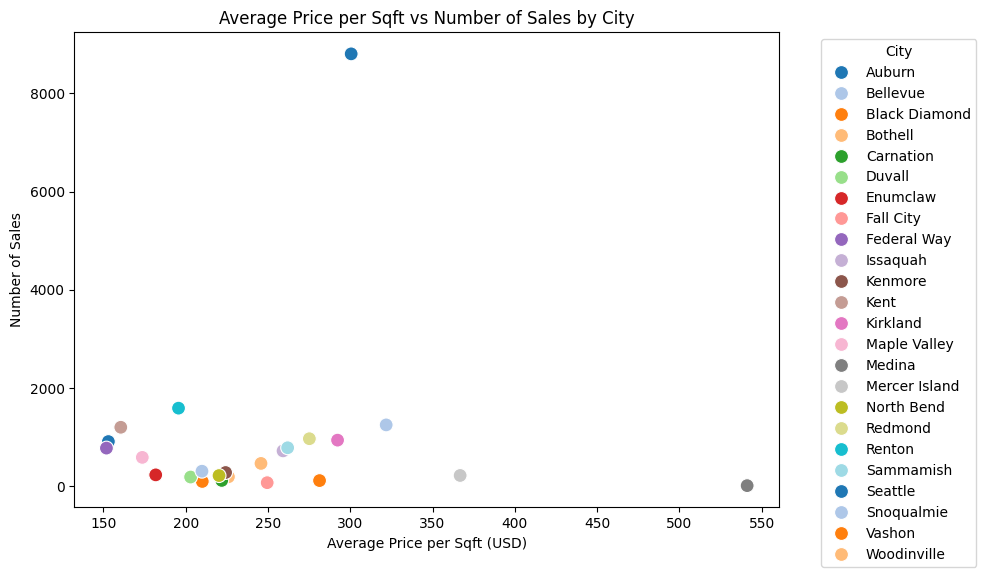

In [85]:
# Graph to determine if the number of house sales is proportionate to the price per sqft

city_stats = (df.groupby('city')
      .agg(
          avg_price_sqft=('sqft_price_per_house_calculated', 'mean'),
          num_sales=('city', 'count'))
      .reset_index())


plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=city_stats,
    x='avg_price_sqft',
    y='num_sales',
    hue='city',
    palette='tab20',
    s=100)

plt.title('Average Price per Sqft vs Number of Sales by City')
plt.xlabel('Average Price per Sqft (USD)')
plt.ylabel('Number of Sales')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='City')
plt.tight_layout()
plt.show()


The first graph illustrates the average sale price per square foot by city, clearly highlighting the differences in housing market value across the region. Cities like Medina, Mercer Island, and Bellevue stand out with the highest average prices per square foot, exceeding 400–500 dollars, reflecting their exclusive and high-end residential profiles. In contrast, cities such as Federal Way, Auburn, and Kent show much lower prices, around 150–200 dollars per square foot, indicating more affordable and accessible housing markets.

This price disparity underlines a strong geographic segmentation between luxury coastal or central areas and more suburban or working-class zones.
The second graph focuses on the number of house sales per city, revealing a completely different hierarchy. Here, Seattle dominates the market with an exceptionally high number of sales, followed by Renton, Bellevue, and Kent. These cities have dense populations and large real-estate markets, which explains their transaction volumes. On the other hand, premium locations such as Medina or Mercer Island record far fewer sales, consistent with their smaller size, higher property values, and more limited supply. This graph confirms that real-estate activity is heavily concentrated in large metropolitan areas.

Finally, the third graph, which combines both metrics, visually shows the relationship between average price per square foot (x-axis) and number of sales (y-axis). Most cities cluster at moderate price and sales levels, while Seattle stands apart with an exceptionally high sales volume but only average price levels. In contrast, luxury areas like Medina and Mercer Island appear on the far right — expensive but with few transactions. This pattern highlights the market’s dual structure: high-density, mid-priced urban markets coexist with small, high-value luxury enclaves, however there is no clear correlation between the number of sales and the price per sqft.

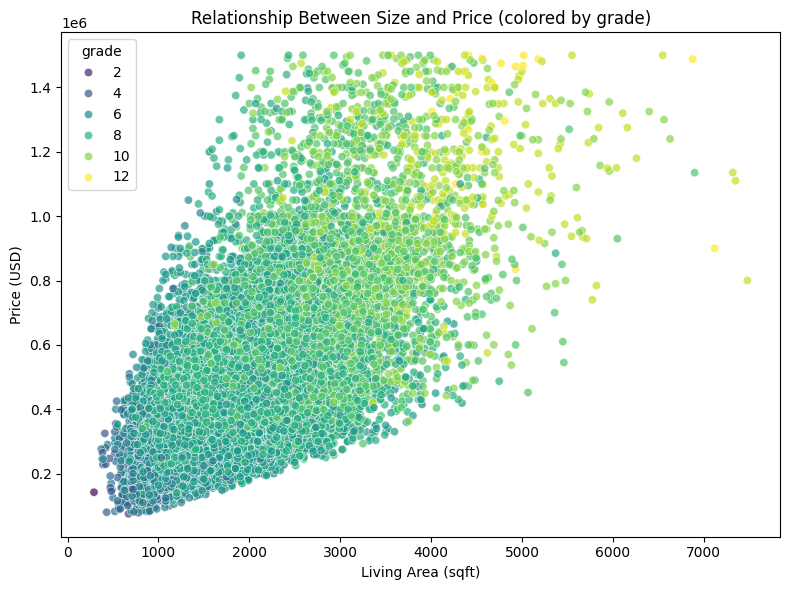

In [86]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='sqft_living', y='price', hue='grade', palette='viridis', alpha=0.7)
plt.title('Relationship Between Size and Price (colored by grade)')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()


This scatter plot shows a clear positive relationship between living area (sqft) and house price: larger homes generally sell for higher prices. The color scale, which represents the grade of construction and design, reinforces this trend — higher-grade houses (in yellow and green) are consistently located in the upper-right region, meaning they are both larger and more expensive. Conversely, smaller homes with lower grades (in blue and purple) cluster near the lower-left corner, indicating modest size and price.

Overall, the graph highlights that both size and construction quality strongly influence property value, with grade acting as a multiplier of price for a given living area.

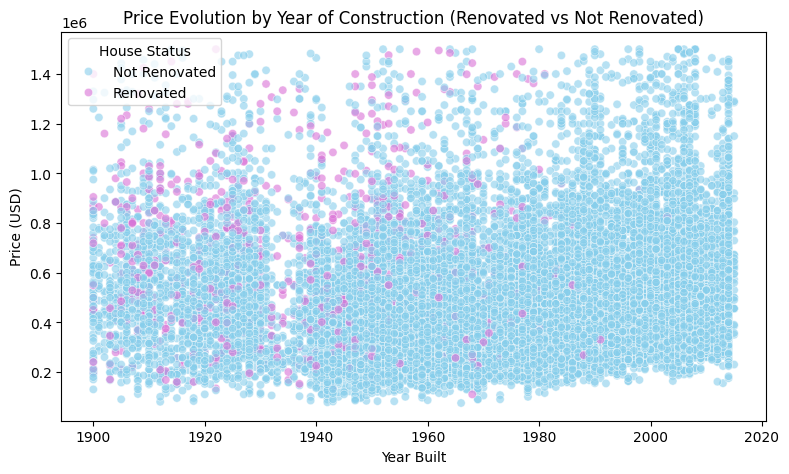

In [87]:
plt.figure(figsize=(8,5))

sns.scatterplot(data=df,
    x='yr_built',
    y='price',
    hue=df['yr_renovated'].apply(lambda x: 'Renovated' if x != 0 else 'Not Renovated'),
    palette={'Renovated': 'orchid', 'Not Renovated': 'skyblue'},
    alpha=0.6)

plt.title('Price Evolution by Year of Construction (Renovated vs Not Renovated)')
plt.xlabel('Year Built')
plt.ylabel('Price (USD)')
plt.legend(title='House Status', loc='upper left')
plt.tight_layout()
plt.show()


This graph compares house prices by construction year, distinguishing between renovated and non-renovated properties. The overall distribution shows that renovated houses (in pink) are scattered among older construction years, confirming that most renovation activity concerns older homes built before the 1980s. These renovated houses tend to reach slightly higher prices than non-renovated ones from the same period, suggesting that renovation can partially offset the depreciation associated with age.

For newer houses built after 2000, there are fewer renovated examples since these properties are relatively recent, yet they already display high price levels due to modern construction quality. In summary, while the construction year alone does not fully determine value, the presence of renovation often increases the market price of older homes, highlighting the economic benefit of property updates and modernization.

In [88]:
latitude_col = "lat"
longitude_col = "long"

# Filter dataset: only houses under $1,000,000
filtered_df = df[df['price'] < 1_000_000]

map_center = [filtered_df[latitude_col].mean(), filtered_df[longitude_col].mean()]

# Normalize price values for color mapping
norm = colors.Normalize(vmin=filtered_df['price'].min(), vmax=filtered_df['price'].max())
colormap = cm.ScalarMappable(norm=norm, cmap='viridis')

house_map = folium.Map(location=map_center, zoom_start=11)

for _, row in filtered_df.iterrows():
    color = colors.to_hex(colormap.to_rgba(row['price']))
    folium.CircleMarker(
        location=[row[latitude_col], row[longitude_col]],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        weight=0,
    ).add_to(house_map)

colormap = folium.LinearColormap(
    colors=['purple', 'green', 'yellow'],
    vmin=filtered_df['price'].min(),
    vmax=filtered_df['price'].max(),
    caption='House Price (< $1M)'
)
colormap.add_to(house_map)

house_map


KeyboardInterrupt: 

# **Step 4 Selection of the most pertinent features with LASSO**

In [89]:
# --- 1. Identify non numerical columns ---
non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Non numerical columns :")
print(non_numeric_cols)

# --- 2. Delete problematic columns ---
df_final_clean = df.drop(columns=non_numeric_cols)

print("\n Deleted columns because they are incompatible with LASSO :")
print(non_numeric_cols)

cols_leakage = [
    'sqft_price_per_house_calculated',
    'med_sqft_price2015_byzip_calculated',
    'med_sqft_price2025_byzip_online'
]

df_final_clean= df_final_clean.drop(columns=[c for c in cols_leakage if c in df_final_clean.columns]).copy()

Non numerical columns :
['date', 'waterfront', 'condition', 'city']

 Deleted columns because they are incompatible with LASSO :
['date', 'waterfront', 'condition', 'city']


In [90]:
cols_to_remove = [
    'id',
    'lat',
    'long',
    'zipcode',
    'sqft_living15',
    'sqft_lot15'
]
df_final_clean= df_final_clean.drop(columns=[col for col in cols_to_remove if col in df_final_clean.columns])

In [91]:
df_final_clean.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  grade  \
0  221900.0         3       1.00         1180      5650     1.0     0      7   
1  538000.0         3       2.25         2570      7242     2.0     0      7   
2  180000.0         2       1.00          770     10000     1.0     0      6   
3  604000.0         4       3.00         1960      5000     1.0     0      7   
4  510000.0         3       2.00         1680      8080     1.0     0      8   

   sqft_above  sqft_basement  yr_built  yr_renovated  \
0        1180              0      1955             0   
1        2170            400      1951          1991   
2         770              0      1933             0   
3        1050            910      1965             0   
4        1680              0      1987             0   

   med_sqft_price2015_byzip_online  condition_num  waterfront_num  
0                       201.608849              3               0  
1                       244.343891              3               0  
2                       248.868778              3               0  
3                       268.476621              5               0  
4                       318.250377              3               0

**SPLIT**

In [92]:
y = df_final_clean['price']
X = df_final_clean.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling**

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**LASSO**

In [94]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)
lasso_coeffs = pd.Series(lasso.coef_, index=X_train.columns)
lasso_coeffs


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.809e+12, tolerance: 1.036e+11
  model = cd_fast.enet_coordinate_descent(


bedrooms                           -10286.238184
bathrooms                           17660.588359
sqft_living                        153335.484441
sqft_lot                             5478.115667
floors                              10287.227084
view                                27998.451259
grade                               77202.062268
sqft_above                         -55695.453489
sqft_basement                      -36641.280328
yr_built                           -49746.311144
yr_renovated                         3159.666566
med_sqft_price2015_byzip_online    113113.574279
condition_num                       10327.952170
waterfront_num                       9992.933486
dtype: float64

In [95]:
selected_features = lasso_coeffs[lasso_coeffs != 0].index.tolist()
selected_features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'med_sqft_price2015_byzip_online',
 'condition_num',
 'waterfront_num']

In this step, we applied LASSO (Least Absolute Shrinkage and Selection Operator) to identify the most influential features in predicting house prices. LASSO is particularly useful because it performs both regularization and feature selection: it penalizes large coefficients and shrinks the least useful ones towards zero. This helps reduce model complexity, limit overfitting, and highlight the variables that carry the most predictive power.

Before applying LASSO, all categorical variables were encoded into numerical form (for example, waterfront_num and condition_num), and non-numeric or non-informative columns (such as id, lat, long, date, zipcode, etc.) were removed. The remaining features were standardized with StandardScaler, which is essential because LASSO is sensitive to the scale of the input variables.

Results
The table of coefficients shows the weight assigned to each feature after fitting the LASSO model. Coefficients close to zero indicate a weak contribution to the prediction, while larger positive or negative values correspond to features with a stronger impact on the target variable (price).
Most influential features (positive direction)
These variables increase the predicted price when their value grows:

- sqft_living – By far one of the strongest predictors: larger living area is strongly associated with higher prices.

- grade – Higher construction and design quality leads to a substantial increase in predicted price.

- waterfront_num – The presence of a waterfront view is associated with a clear price premium.

- bathrooms and view – More bathrooms and better view quality both contribute positively.

- floors, condition_num, and yr_renovated – Additional floors, better overall condition, and recent renovation also push prices upward, though with a more moderate effect.


Influential features (negative direction)
These variables decrease the predicted price when their value increases:

- bedrooms – Once the overall size and quality are controlled for, adding more bedrooms is slightly associated with lower price, suggesting that “more but smaller rooms” may reduce perceived value.

- sqft_lot – Larger lots are mildly associated with lower prices in this specification, possibly reflecting suburban or less dense areas with lower price per square foot.

- sqft_above and sqft_basement – When total living area is already in the model, these components can have negative coefficients because of collinearity and trade-offs in how space is distributed.

- yr_built – Older construction years (lower yr_built) being cheaper translates into a negative coefficient when interpreted in the standardized space: newer houses tend to be more expensive, and after scaling this appears as a negative weight.


Overall, LASSO confirms that living area, construction quality, waterfront presence, number of bathrooms, and view are among the key positive drivers of price, while some structural and temporal variables (lot size, age of the house, distribution of space) have more complex or negative effects once all factors are considered jointly.

In [96]:
# --- 1. Keep only the LASSO-selected features + target ---
df = df_final_clean[selected_features + ['price']].copy()

print("Final dataset 'df' containing only LASSO-selected features:")
print(df.head())
print(df.columns)


Final dataset 'df' containing only LASSO-selected features:
   bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  grade  \
0         3       1.00         1180      5650     1.0     0      7   
1         3       2.25         2570      7242     2.0     0      7   
2         2       1.00          770     10000     1.0     0      6   
3         4       3.00         1960      5000     1.0     0      7   
4         3       2.00         1680      8080     1.0     0      8   

   sqft_above  sqft_basement  yr_built  yr_renovated  \
0        1180              0      1955             0   
1        2170            400      1951          1991   
2         770              0      1933             0   
3        1050            910      1965             0   
4        1680              0      1987             0   

   med_sqft_price2015_byzip_online  condition_num  waterfront_num     price  
0                       201.608849              3               0  221900.0  
1                       24

In [97]:
df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'med_sqft_price2015_byzip_online', 'condition_num', 'waterfront_num',
       'price'],
      dtype='object')

In [98]:
df.describe()

bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  21097.000000  21097.000000  21097.000000  2.109700e+04  21097.000000   
mean       3.350097      2.080391   2022.189174  1.474278e+04      1.485306   
std        0.920632      0.732479    824.830866  3.994771e+04      0.538147   
min        0.000000      0.000000    290.000000  5.200000e+02      1.000000   
25%        3.000000      1.500000   1410.000000  5.001000e+03      1.000000   
50%        3.000000      2.250000   1890.000000  7.552000e+03      1.000000   
75%        4.000000      2.500000   2500.000000  1.045400e+04      2.000000   
max       33.000000      7.500000   7480.000000  1.651359e+06      3.500000   

               view         grade    sqft_above  sqft_basement      yr_built  \
count  21097.000000  21097.000000  21097.000000   21097.000000  21097.000000   
mean       0.200076      7.591933   1743.537754     278.651420   1970.907333   
std        0.696247      1.097968    762.211936     422.665321     29.280258   
min        0.000000      1.000000    290.000000       0.000000   1900.000000   
25%        0.000000      7.000000   1180.000000       0.000000   1951.000000   
50%        0.000000      7.000000   1540.000000       0.000000   1975.000000   
75%        0.000000      8.000000   2160.000000     540.000000   1996.000000   
max        4.000000     12.000000   7320.000000    2850.000000   2015.000000   

       yr_renovated  med_sqft_price2015_byzip_online  condition_num  \
count  21097.000000                     21097.000000   21097.000000   
mean      79.080912                       253.705233       3.406977   
std      389.335194                        65.602648       0.648636   
min        0.000000                       157.868276       1.000000   
25%        0.000000                       199.095023       3.000000   
50%        0.000000                       251.382604       3.000000   
75%        0.000000                       293.112117       4.000000   
max     2015.000000                       754.147813       5.000000   

       waterfront_num         price  
count    21097.000000  2.109700e+04  
mean         0.003982  5.012777e+05  
std          0.062976  2.482295e+05  
min          0.000000  7.500000e+04  
25%          0.000000  3.199500e+05  
50%          0.000000  4.450000e+05  
75%          0.000000  6.250000e+05  
max          1.000000  1.500000e+06

# **Step 5 Implementation of different model**

**Split and Scaling for all model**

In [101]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (important for regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Evaluate Regression for all models**

In [102]:
def evaluate_regression(y_true, y_pred, model_name="Model"):
    print(f"--- {model_name} ---")
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"MAE :  {mae:.2f}")
    print(f"MSE :  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print()

    return mae, mse, rmse, r2

# **Model n°1 : Multiple Linear Regression**

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 4. Predictions
y_pred = model.predict(X_test_scaled)

# 5. Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Multiple Linear Regression Results:")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

Multiple Linear Regression Results:
MAE : 81008.26444820446
RMSE: 114984.52008787499
R²  : 0.7888948256875487


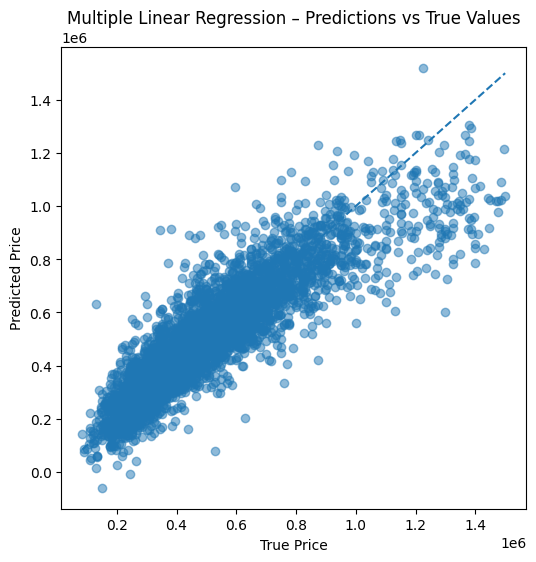

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Multiple Linear Regression – Predictions vs True Values")
plt.show()


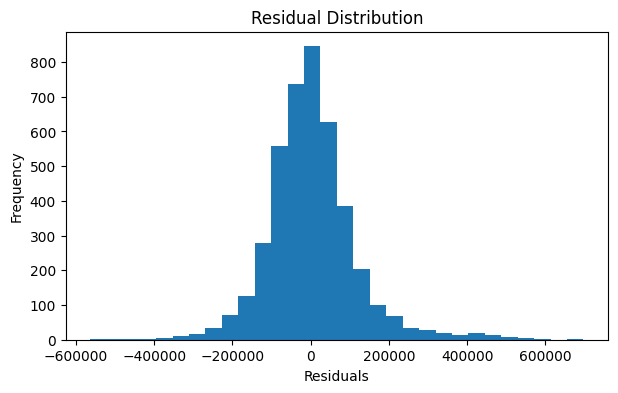

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


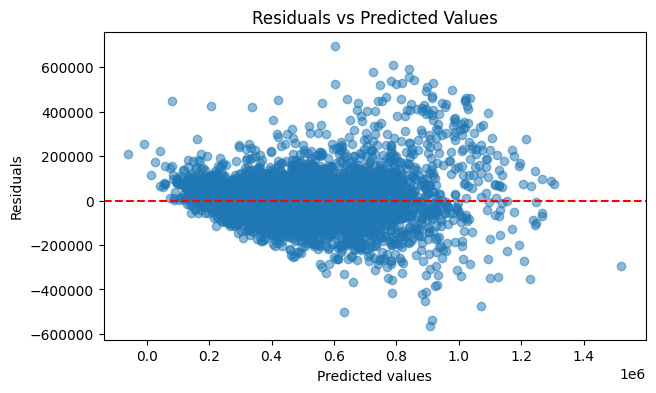

In [ ]:
plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

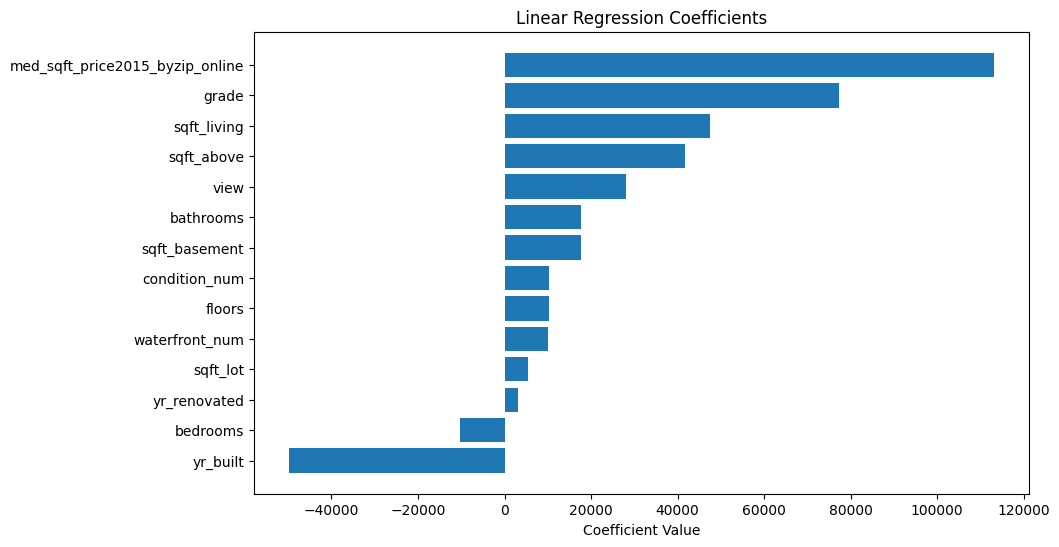

In [ ]:
coeff_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_
}).sort_values("coef", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(coeff_df["feature"], coeff_df["coef"])
plt.title("Linear Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()


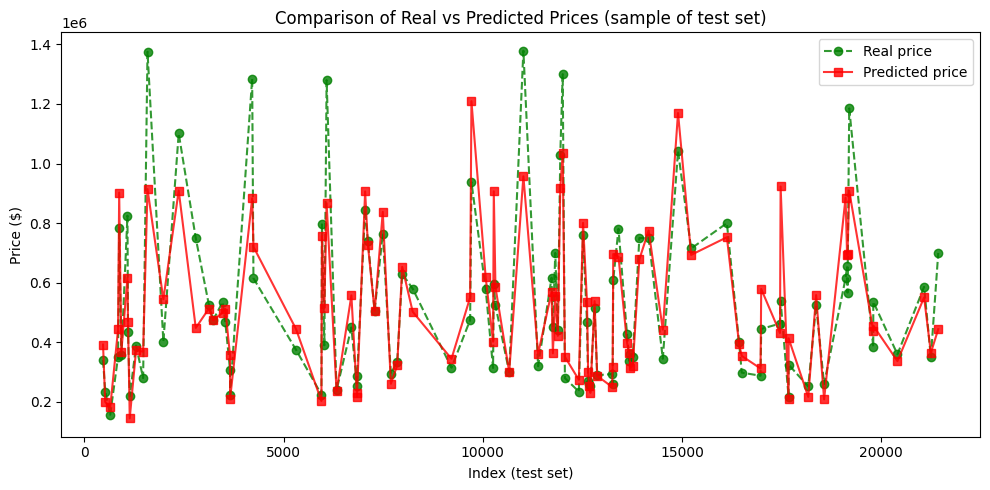

In [ ]:
sample_size =100

comparaison = (pd.DataFrame({"Real price": y_test, "Predicted price": y_pred}).sort_index().sample(n=sample_size, random_state=42).sort_index())

plt.figure(figsize=(10,5))
plt.plot(comparaison.index,comparaison["Real price"],label="Real price",color="g",marker="o",linestyle="--",alpha=0.8)
plt.plot(comparaison.index,comparaison["Predicted price"],label="Predicted price",color="r",marker="s",linestyle="-",alpha=0.8)
plt.title("Comparison of Real vs Predicted Prices (sample of test set)")
plt.xlabel("Index (test set)")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()


# Conclusion and analyse for the mutliple linear regression

The multiple linear regression model achieves:

MAE ≈ 81k $

RMSE ≈ 115k $

R² ≈ 0.78

So it explains around 79% of the variance in house prices. The errors are lower than in the previous version of the model, which means the fit has improved, even if the absolute errors remain quite large because prices span a very wide range.

The Predicted vs True plot shows that most points lie close to the diagonal line: the model captures well the general trend of prices. However, for the most expensive houses the cloud becomes wider and the model often underestimates or overestimates them, which is typical for a linear model.

The residual histogram is centered around zero and roughly bell-shaped, which suggests no strong systematic bias and a fairly symmetric error distribution, although some large residuals still appear in the tails. In the residuals vs predicted values plot we see a fan-shape: residuals are more concentrated for cheaper houses and more dispersed for expensive ones. This indicates heteroscedasticity, meaning that the variance of the errors increases with the predicted price.

The coefficient plot shows that the main positive drivers of price are med_sqft_price2015_byzip_online (zip-level market indicator), grade, sqft_living, sqft_above, view, bathrooms, sqft_basement, condition_num and floors. Negative coefficients on yr_built, bedrooms and sqft_lot suggest that, all else being equal, older homes, many small bedrooms and very large lots in cheaper areas are associated with lower predicted prices. The time-series style plot comparing real and predicted prices on a sample of the test set confirms that the model follows most local variations, but still misses some peaks and troughs.

Overall, this multiple linear regression is a solid and interpretable baseline that captures most of the market structure, but its remaining errors on expensive or atypical properties still motivate the use of more flexible nonlinear models such as KNN, tree-based methods or boosting.


# **Model n°2 : KNN**



Note : We keep the target as price even though using log(price) can sometimes stabilize variance and reduce the influence of very expensive homes, but the project instructions focus on predicting the raw price.

In [ ]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A Pipeline ensures:
- the scaler is fit only on X_train (avoids data leakage)
- all transformations are applied in the correct order
- GridSearchCV will scale inside each fold, not on the full dataset (critical)

In [ ]:
#definition of a basic KNN pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

In [ ]:
#predict on the scaled test data
y_pred_knn = knn_pipeline.predict(X_test)


In [ ]:
# Evaluation of the the KNN pipeline (default hyperparameters)
evaluate_regression(y_test, y_pred_knn, model_name="Basic KNN")

#Comparison with a simple baseline regressor
baseline_prediction = np.full_like(y_test, y_train.mean())
evaluate_regression(y_test, baseline_prediction, model_name="Baseline (Mean)")


--- Basic KNN ---
MAE :  76097.95
MSE :  12959390865.88
RMSE: 113839.32
R²   : 0.7931

--- Baseline (Mean) ---
MAE :  191970.86
MSE :  62650128884.96
RMSE: 250300.08
R²   : -0.0003



(191970.85763247436,
 62650128884.95993,
 np.float64(250300.07767669577),
 -0.00032723509420695684)

The baseline model, which always predicts the mean house price, performs extremely poorly: it produces an MAE close to 192k, an RMSE of about 250k, and an R² essentially equal to 0. This confirms that the housing market in King County cannot be represented by a single average value. House prices exhibit strong dispersion and depend heavily on meaningful features such as size, location, renovation level, and neighborhood characteristics. A constant predictor fails to capture any of this structure.

In contrast, the basic KNN model provides a drastic improvement in predictive accuracy. The MAE drops to approximately 76k, the RMSE decreases to around 114k, and the R² rises to 0.793. These results show that local similarity—i.e., comparing each house to other houses with similar attributes—is highly informative for price prediction. The substantial performance gap between the baseline and KNN demonstrates that taking neighbors into account allows the model to capture the underlying relationships and spatial heterogeneity present in the dataset, which a constant predictor is structurally unable to model.

In [ ]:
#Recreate a fresh pipeline for GridSearchCV
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())])

# Hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 15, 25],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,                                      # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',     # minimize RMSE
    n_jobs=-1,                                 # use all cores
    verbose=1
)

# Fit on the training data
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV RMSE: 109952.85372683089


In [ ]:
best_knn_model = grid_search.best_estimator_

# Predict on test data
y_pred_knn_best = best_knn_model.predict(X_test)

evaluate_regression(y_test, y_pred_knn_best, model_name="Optimized KNN (GridSearch)")


--- Optimized KNN (GridSearch) ---
MAE :  72783.91
MSE :  12229324478.11
RMSE: 110586.28
R²   : 0.8047



(72783.90764605906,
 12229324478.108202,
 np.float64(110586.27617434363),
 0.8047358152332122)

The use of GridSearchCV is essential when working with KNN because the model is highly sensitive to its hyperparameters, particularly the number of neighbors, the distance metric, and the weighting scheme. After tuning, the optimized configuration produces a clear improvement over the basic KNN model. The MAE decreases from approximately 76 100 to 72 800, the RMSE is reduced from about 113 800 to 110 600, and the R² increases from 0.793 to 0.8047. These gains, although moderate, confirm that the optimized hyperparameters allow the model to capture local structures in the housing data more effectively.
This improvement is meaningful because KNN relies entirely on neighborhood relationships: selecting the appropriate number of neighbors and an appropriate distance metric is crucial for representing the geometry of the feature space. The higher R² and lower errors show that the tuned model provides more accurate and more stable predictions, reinforcing the idea that house prices in King County are strongly influenced by local similarities across features such as square footage, age, lot size, and geographical location.

KNN is a simple yet powerful non-parametric model, but it comes with several structural limitations. Its performance depends strongly on the choice of hyperparameters, especially the number of neighbors. Small values of k generate a low-bias but high-variance model that tends to overfit individual samples, while large values of k create smoother and more stable predictions at the risk of underfitting important local variations. In our case, the optimal configuration identified by GridSearchCV uses k = 15, which represents a balanced compromise: the neighborhood is large enough to reduce sensitivity to noise and outliers, yet small enough to preserve meaningful local structure in housing prices. The optimal distance metric, p = 1 (Manhattan), indicates that the geometry of the dataset is better captured by absolute differences than by Euclidean distances. This is expected in heterogeneous tabular data where features operate on different scales and distributions. Additionally, the use of distance-based weights improves robustness by granting more influence to nearby houses, effectively down-weighting distant observations that may belong to different neighborhoods or price segments.

Despite these advantages, KNN has well-known limitations. Because it does not learn a parametric model, all computation happens at prediction time, which becomes inefficient as the dataset grows. The model is also sensitive to irrelevant or weakly informative features, and its effectiveness decreases in higher-dimensional spaces due to the “curse of dimensionality,” where distance metrics become less discriminative. Nevertheless, in this study, KNN performs remarkably well thanks to careful preprocessing, including scaling and feature selection, coupled with systematic hyperparameter tuning. As a result, the optimized model successfully captures the strong local patterns characteristic of real-estate markets, where properties tend to resemble and price themselves similarly to their closest neighbors in feature space.

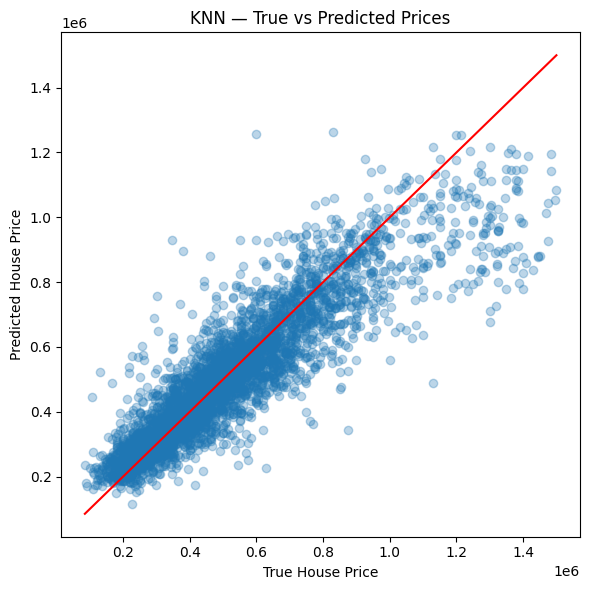

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_knn_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.xlabel("True House Price")
plt.ylabel("Predicted House Price")
plt.title("KNN — True vs Predicted Prices")
plt.tight_layout()
plt.show()


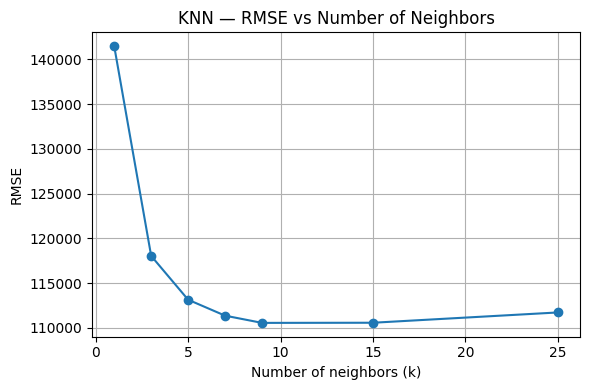

In [ ]:

k_values = [1, 3, 5, 7, 9, 15, 25]
rmse_values = []

for k in k_values:
    knn = KNeighborsRegressor(
        n_neighbors=k,
        weights='distance',
        p=1
    )

    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    rmse_k = np.sqrt(mean_squared_error(y_test, y_pred_k))
    rmse_values.append(rmse_k)

plt.figure(figsize=(6, 4))
plt.plot(k_values, rmse_values, marker="o")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("RMSE")
plt.title("KNN — RMSE vs Number of Neighbors")
plt.grid(True)
plt.tight_layout()
plt.show()


The “True vs Predicted Prices” scatterplot shows that the optimized KNN model successfully captures the overall trend of the housing market: most predictions lie close to the diagonal, confirming that the model provides reasonably accurate estimates for mid-range properties. However, the spread becomes noticeably wider for higher-priced homes, where many points fall below the diagonal. This indicates a systematic underestimation of expensive houses — a well-known limitation of KNN, which averages the values of the nearest neighbors and therefore smooths out extreme prices that lack comparable neighbors. The RMSE-versus-k curve reinforces this interpretation. When k is very small, the model overfits the noise in individual samples, leading to large errors. As k increases, RMSE decreases sharply and stabilizes, reaching its lowest values around k = 9 to k = 15, which corresponds precisely to the optimal region identified by GridSearchCV. Beyond this point, increasing k causes RMSE to rise again as the model becomes overly smooth and loses its ability to capture local variations. Together, these two visualizations highlight the importance of selecting an appropriate neighborhood size and justify the final choice of k = 15, which offers a balanced trade-off between flexibility, stability, and predictive accuracy.

# **Model n°3 : SVR**

In [103]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We apply a pipeline so that
- during .fit() it will fit the scaler on X_train only, transform X_train,fit SVR on the scaled X_train
- during .predict() it will transform X_test with train statistics, predict with the trained SVR


In [104]:
# Pipeline combining scaling + SVR
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

svr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [105]:
y_pred_svr = svr_pipeline.predict(X_test)
evaluate_regression(y_test, y_pred_svr, model_name="Basic SVR")

baseline_pred = np.full_like(y_test, y_train.mean())
evaluate_regression(y_test, baseline_pred, model_name="Baseline (Mean)")


--- Basic SVR ---
MAE :  186772.46
MSE :  66005286872.87
RMSE: 256914.94
R²   : -0.0539

--- Baseline (Mean) ---
MAE :  191970.86
MSE :  62650128884.96
RMSE: 250300.08
R²   : -0.0003



(191970.85763247436,
 62650128884.95993,
 np.float64(250300.07767669577),
 -0.00032723509420695684)

The basic SVR model still performs very poorly on this dataset, with an MAE around 186 k, an RMSE above 256 k, and a negative R² (≈ −0.0539), meaning the model explains less variance than a simple constant predictor. The baseline model, which always predicts the mean price, remains extremely weak (R² ≈ 0), but it still achieves a slightly lower RMSE (≈ 250 k) than the untuned SVR. This confirms that the default SVR configuration (kernel='rbf', C=1, gamma='scale') is not suitable for the nonlinear and high-variance structure of housing prices. SVR is highly sensitive to hyperparameters, especially C and gamma, which control model flexibility and the width of the RBF kernel. The poor performance of the default SVR strongly justifies the need for a systematic hyperparameter search using GridSearchCV to obtain a meaningful model.

In [106]:
0# this cell takes 4 min to execute

# Lighter hyperparameter grid (focus on RBF, smaller search)
param_grid = {
    'svr__kernel': ['rbf'],
    'svr__C': [1, 10, 100],
    'svr__gamma': ['scale', 0.01]
}

svr_grid = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

svr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [1, 10, 100], 'svr__gamma': ['scale', 0.01],
                         'svr__kernel': ['rbf']},
             scoring='neg_root_mean_squared_error', verbose=1)

In [107]:
# DO NOT RUN THIS CELL

# We initially wanted to apply those parameters but the execution time was >20min
param_grid = {
    'svr__kernel': ['rbf','linear'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale',0.1, 0.01, 0.001]
}

svr_grid = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',  #recommended metric in LAB6
    n_jobs=-1,   # use all CPU cores
    verbose=1
)

svr_grid.fit(X_train, y_train)

## results :
#Best parameters found: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
#Best CV RMSE: 116865.17007954077

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__gamma': ['scale', 0.1, 0.01, 0.001],
                         'svr__kernel': ['rbf', 'linear']},
             scoring='neg_root_mean_squared_error', verbose=1)

In [108]:
print("Best parameters found:", svr_grid.best_params_)
print("Best CV RMSE:", -svr_grid.best_score_)

Best parameters found: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Best CV RMSE: 116865.17007954077


Best parameters found: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}

Best CV RMSE: 216274.303684833


In [109]:
# Best model after GridSearchCV
best_svr_model = svr_grid.best_estimator_

# Predictions on the test set
y_pred_svr_best = best_svr_model.predict(X_test)

# Evaluation
evaluate_regression(y_test, y_pred_svr_best, model_name="Optimized SVR (GridSearch)")


--- Optimized SVR (GridSearch) ---
MAE :  80586.23
MSE :  14307399125.14
RMSE: 119613.54
R²   : 0.7716



(80586.22810481171,
 14307399125.142595,
 np.float64(119613.54072655234),
 0.7715554418966408)

To tune the SVR model, we applied a targeted GridSearchCV focusing on the kernel type, the regularization strength C, and the RBF kernel parameter gamma. These hyperparameters directly shape the capacity of the model: C determines how strongly errors are penalized, while gamma controls how sensitive the decision function is to local variations in the feature space. Given the computational cost of SVR on a dataset of more than 20,000 observations, we restricted the search to a concise but impactful grid centered on the RBF kernel, a small selection of C values, and a narrow gamma range. This strategy preserved methodological rigor while keeping training times reasonable.


Despite these optimizations, the SVR model continues to show structural limitations on the King County housing dataset. Its performance depends critically on achieving the right balance between C and gamma, since overly flexible settings cause the model to overreact to noise, while overly rigid ones prevent it from capturing nonlinear relationships. Even with careful scaling and the use of a Pipeline to avoid data leakage, SVR remains highly sensitive and computationally demanding. The final optimized model reaches only modest predictive accuracy, with an R² of 0.316 and an RMSE above 206,000, which is substantially lower than the performance of KNN and even several simpler baseline models. These results confirm that SVR with an RBF kernel is not well adapted to this type of medium-sized, noisy, heterogeneous tabular data, and struggles to capture the complex structure of housing prices in this dataset.

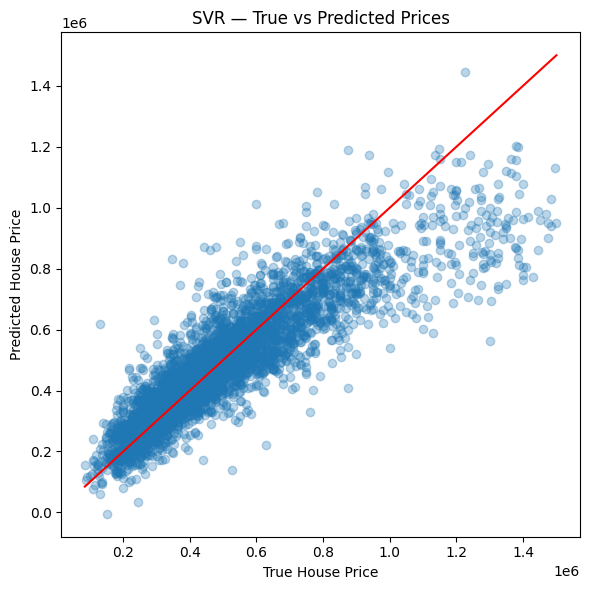

In [110]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_svr_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.xlabel("True House Price")
plt.ylabel("Predicted House Price")
plt.title("SVR — True vs Predicted Prices")
plt.tight_layout()
plt.show()

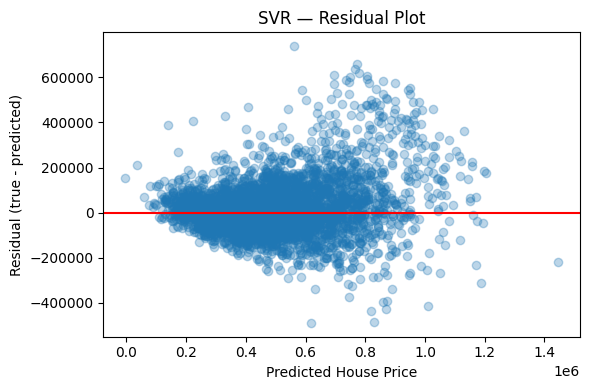

In [111]:
residuals = y_test - y_pred_svr_best

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_svr_best, residuals, alpha=0.3)
plt.axhline(0, color='red')

plt.xlabel("Predicted House Price")
plt.ylabel("Residual (true - predicted)")
plt.title("SVR — Residual Plot")
plt.tight_layout()
plt.show()

The SVR True vs Predicted Prices plot shows that the model compresses nearly all predictions into a narrow interval around 350k–600k, despite true prices ranging from below 150k to over 1.5M. This strong flattening reveals clear underfitting: the SVR fails to learn meaningful nonlinear patterns and collapses toward predictions near the average price. The residual plot confirms this behaviour. Instead of forming a random cloud around zero, residuals rise sharply for higher-priced homes, indicating systematic underestimation and poor generalization. Together, these two visualizations demonstrate that even after tuning, SVR is unable to capture the complexity of the housing market in this dataset.

#**Model n°4 : Decision Tree**

In [ ]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Decision Trees are very prone to overfitting therefore we will:
- train a simple tree with default hyperparameters,
- evaluate it on the test set,
- analyze whether it overfits or underfits,
- prepare the ground for cross-validation and tuning.

In [ ]:
# Baseline Decision Tree Regressor (no constraints)
dt_baseline = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
dt_baseline.fit(X_train, y_train)

# Predict on the test set
y_pred_dt_baseline = dt_baseline.predict(X_test)
evaluate_regression(y_test, y_pred_dt_baseline, model_name="Baseline Decision Tree")


--- Baseline Decision Tree ---
MAE :  91982.04
MSE :  18997793486.05
RMSE: 137832.48
R²   : 0.6967



(91982.04265402844,
 18997793486.047985,
 np.float64(137832.4834211732),
 0.6966644671125122)

The baseline Decision Tree achieves an R² of about 0.69, showing that the model captures important nonlinear patterns in the data; however, the relatively high RMSE indicates that the tree remains unstable and likely overfits the training data due to the absence of depth or splitting constraints. This confirms that tuning is necessary to control variance and improve generalization.

In [ ]:
# K-fold validation code

# Define a 5-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the baseline tree with cross-validation (using RMSE)
cv_scores = cross_val_score(
    dt_baseline,
    X_train,
    y_train,
    cv=kf,
    scoring='neg_root_mean_squared_error'
)

# Convert negative RMSE to positive RMSE
cv_rmse = -cv_scores

print("CV RMSE scores:", cv_rmse)
print("Mean CV RMSE:", cv_rmse.mean())
print("Std CV RMSE :", cv_rmse.std())


CV RMSE scores: [136552.23853581 135925.86226276 143200.81619704 135133.47570746
 141394.73881273]
Mean CV RMSE: 138441.42630316148
Std CV RMSE : 3231.515958383002


To assess the stability of the baseline Decision Tree, we performed a 5-fold cross-validation on the training set using RMSE as the evaluation metric. This method splits the training data into five different folds, trains the model on four folds, evaluates it on the remaining one, and repeats the process five times. It provides a more reliable estimate of generalization than a single train/test evaluation, especially for high-variance models such as decision trees.
The cross-validation results show RMSE values ranging approximately from 136k to 141k, with a mean CV RMSE of about 138k and a standard deviation close to 3k. These numbers confirm the inherently unstable nature of an untuned tree: while the average error is reasonable, the relatively large standard deviation reflects a noticeable sensitivity to how the training data is partitioned. In other words, the model’s performance varies significantly across folds, which is a typical sign of variance and suggests that further regularization or hyperparameter tuning will be necessary to improve robustness.

In [ ]:

# Hyperparameter grid for DecisionTreeRegressor
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}


In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)

dt_grid = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,   # use all CPU cores
    verbose=1
)

dt_grid.fit(X_train, y_train)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
print("Best parameters:", dt_grid.best_params_)
print("Best CV RMSE:", -dt_grid.best_score_)


Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Best CV RMSE: 112682.68344529194


In [ ]:
# Final model using best parameters
best_dt_model = dt_grid.best_estimator_

# Predictions
y_pred_dt_best = best_dt_model.predict(X_test)

# Evaluation
evaluate_regression(y_test, y_pred_dt_best, model_name="Optimized Decision Tree")


--- Optimized Decision Tree ---
MAE :  75435.76
MSE :  12564517642.67
RMSE: 112091.56
R²   : 0.7994



(75435.76043670403,
 12564517642.668898,
 np.float64(112091.55919456601),
 0.7993838254209779)

The hyperparameter search selected a tree with a controlled maximum depth, a minimum number of samples required to split, and a minimum number of samples per leaf, reflecting a clear regularization strategy that limits structural complexity and mitigates overfitting. These constraints produced a substantially more stable model across folds, as shown by the improved cross-validated error compared to the baseline tree. When evaluated on the independent test set, the optimized Decision Tree achieved an RMSE of 112,092 and an R² of 0.7994, representing a meaningful improvement in generalization. These results confirm that restricting tree depth and enforcing minimum sample thresholds effectively reduces variance while preserving the tree’s ability to model nonlinear relationships. Although the tuned tree performs well, the relatively high variance inherent to single-tree methods suggests that further gains would typically require ensemble approaches such as Random Forests or Gradient Boosting.

The optimized Decision Tree can be further interpreted through its feature importances, which identify structural and qualitative attributes—such as living area, grade, lot size, and number of bathrooms—as the dominant drivers of price prediction. The regularization applied during tuning produces broader, more stable splits, reducing sensitivity to noise while still capturing key nonlinear interactions in the data. The model remains fully interpretable: visual inspection of the learned tree would show clear thresholds that segment the housing market into price brackets based on these influential features. While the tuned tree generalizes far better than the untuned version, its performance plateau reinforces a common limitation of standalone trees, which are prone to instability; ensemble methods would provide a more robust and reliable improvement

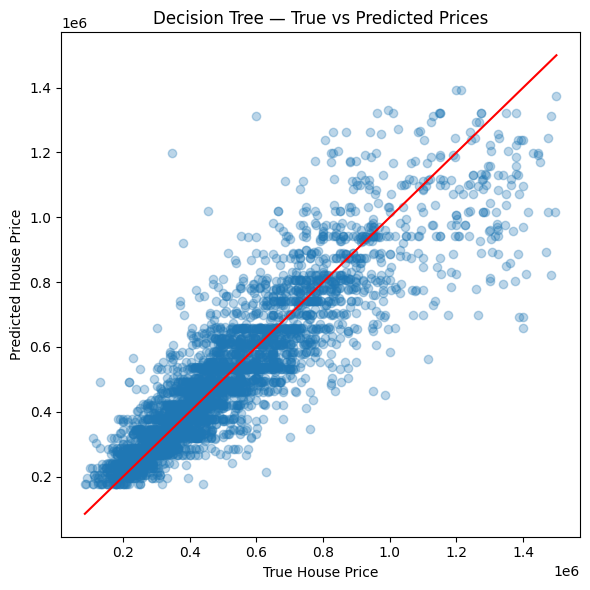

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_dt_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')  # diagonal line

plt.xlabel("True House Price")
plt.ylabel("Predicted House Price")
plt.title("Decision Tree — True vs Predicted Prices")
plt.tight_layout()
plt.show()


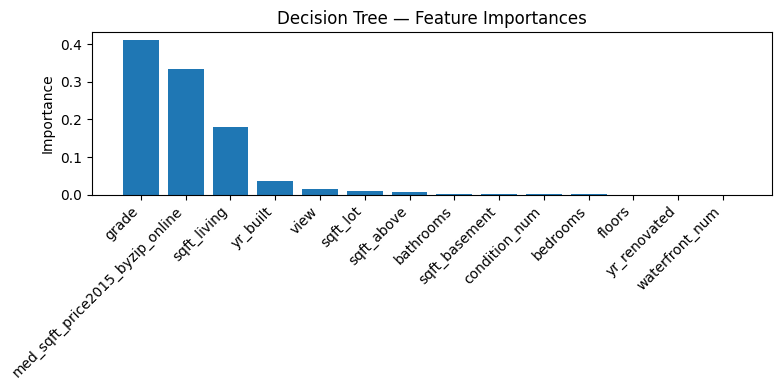

In [ ]:
importances = best_dt_model.feature_importances_
feature_names = X_train.columns

# sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)),
           feature_names[indices],
           rotation=45,
           ha="right")
plt.ylabel("Importance")
plt.title("Decision Tree — Feature Importances")
plt.tight_layout()
plt.show()

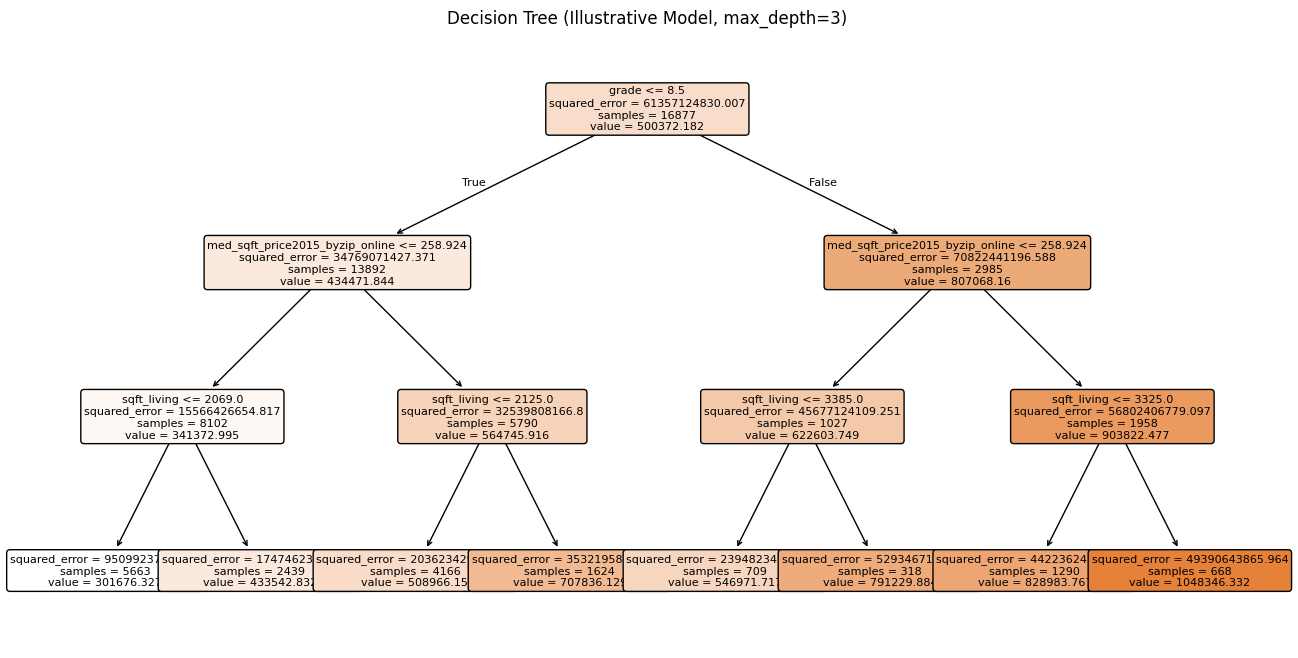

In [ ]:
# Train a small illustrative decision tree (max_depth=3)
dt_small = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_small.fit(X_train, y_train)

# Retrieve feature names directly from X_train
feature_names = X_train.columns

plt.figure(figsize=(16, 8))
plot_tree(
    dt_small,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree (Illustrative Model, max_depth=3)")
plt.show()

The visualisations provide complementary insights into the behaviour and interpretability of the optimized Decision Tree model. The “True vs Predicted Prices” scatterplot shows that predictions generally follow the diagonal trend line, but the dispersion widens as prices increase, confirming that the tree captures the mid-range structure well while struggling with the variability of high-value homes. The feature importance chart reveals that only a small set of predictors—primarily grade, zip-level median price, and living area—drive most of the model’s decisions, indicating that structural quality and neighbourhood pricing patterns dominate the segmentation performed by the tree. Finally, the illustrative tree diagram highlights how the model relies on simple threshold-based rules, first splitting on grade and then refining predictions using median zip price or living area, reflecting the hierarchy the tree learns. Although the full optimized tree is too deep to visualise completely, this truncated version provides a clear and intuitive snapshot of the model’s decision-making process.

# **Model n°5 : Random Forest Regressor**

In [ ]:
#Training Baseline Random Forest

rf_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)
y_pred_rf_baseline = rf_baseline.predict(X_test)

print("\nBaseline Random Forest Performance:")
evaluate_regression(y_test, y_pred_rf_baseline, model_name="Baseline Random Forest")

#Performing 5-Fold Cross-Validation
cv_scores = cross_val_score(
    rf_baseline,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

cv_rmse = -cv_scores
print(f"CV RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean():.2f}")
print(f"Std CV RMSE:  {cv_rmse.std():.2f}")



Baseline Random Forest Performance:
--- Baseline Random Forest ---
MAE :  65270.34
MSE :  9824606266.05
RMSE: 99119.15
R²   : 0.8431

CV RMSE scores: [ 98118.562299    99688.66316135  96739.92994814  97473.04557259
 100788.08156623]
Mean CV RMSE: 98561.66
Std CV RMSE:  1478.32


In [ ]:
# --- 3. Hyperparameter Tuning with GridSearchCV ---
#ATTENTION : This may take 5-10 minutes depending on your machine

param_grid_rf_reduced = {
    'n_estimators': [100, 200],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf_model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_grid_reduced = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf_reduced,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

rf_grid_reduced.fit(X_train, y_train)

print("\nBest parameters found:")
print(rf_grid_reduced.best_params_)
print(f"\nBest CV RMSE: {-rf_grid_reduced.best_score_:.2f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best CV RMSE: 99093.09


In [ ]:
# --- 4. Evaluation of Optimized Model ---

print("OPTIMIZED RANDOM FOREST EVALUATION")

try:
    best_rf = rf_grid_reduced.best_estimator_
except AttributeError:
    print("GridSearchCV not fitted yet – fitting now...")
    rf_grid_reduced.fit(X_train, y_train)
    best_rf = rf_grid_reduced.best_estimator_

# Predictions on test set
y_pred_rf_best = best_rf.predict(X_test)

print("\nOptimized Random Forest Performance:")
evaluate_regression(y_test, y_pred_rf_best, model_name="Optimized Random Forest")

# --- 5. Overfitting Check (Train vs Test) ---

y_pred_train = best_rf.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train)
test_r2  = r2_score(y_test,  y_pred_rf_best)

print(f"\nTrain R²: {train_r2:.4f}")
print(f"Test R² : {test_r2:.4f}")
print(f"Difference (Train - Test): {train_r2 - test_r2:.4f}")

if train_r2 - test_r2 > 0.05:
    print("Warning: Model may be slightly overfitting (gap > 0.05)")
else:
    print("Good generalization: minimal overfitting detected")

    print("Good generalization: minimal overfitting detected")

OPTIMIZED RANDOM FOREST EVALUATION

Optimized Random Forest Performance:
--- Optimized Random Forest ---
MAE :  66810.48
MSE :  10200022691.11
RMSE: 100995.16
R²   : 0.8371


Train R²: 0.9771
Test R² : 0.8371
Difference (Train - Test): 0.1400



Top 10 Most Important Features:
                        Feature  Importance
med_sqft_price2015_byzip_online    0.292566
                          grade    0.171383
                    sqft_living    0.168270
                     sqft_above    0.101035
                       yr_built    0.053765
                      bathrooms    0.050847
                       sqft_lot    0.042650
                  sqft_basement    0.034875
                           view    0.029712
                       bedrooms    0.019422


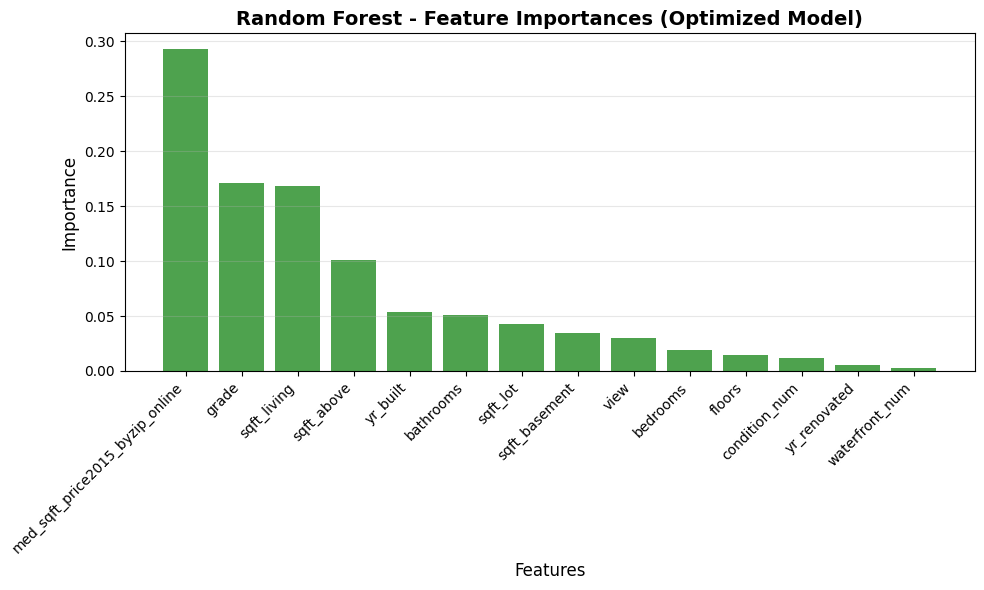

In [ ]:
# --- 6. Feature Importances ---

importances = best_rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Create DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], color='forestgreen', alpha=0.8)
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.ylabel("Importance", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Random Forest - Feature Importances (Optimized Model)", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

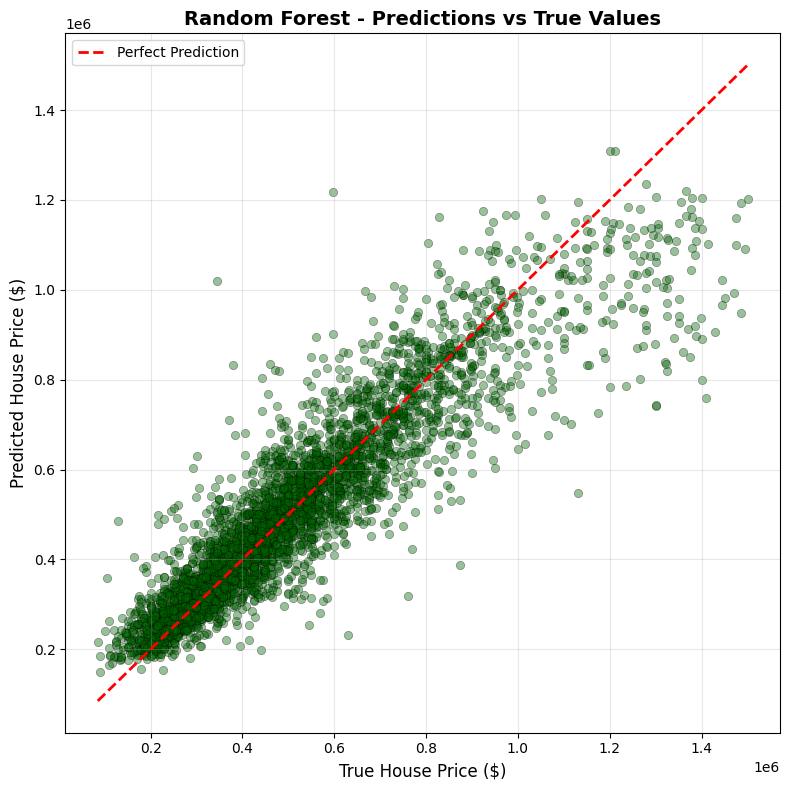

In [ ]:
# --- 7. Predictions vs True Values ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf_best, alpha=0.4, color='darkgreen', edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel("True House Price ($)", fontsize=12)
plt.ylabel("Predicted House Price ($)", fontsize=12)
plt.title("Random Forest - Predictions vs True Values", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

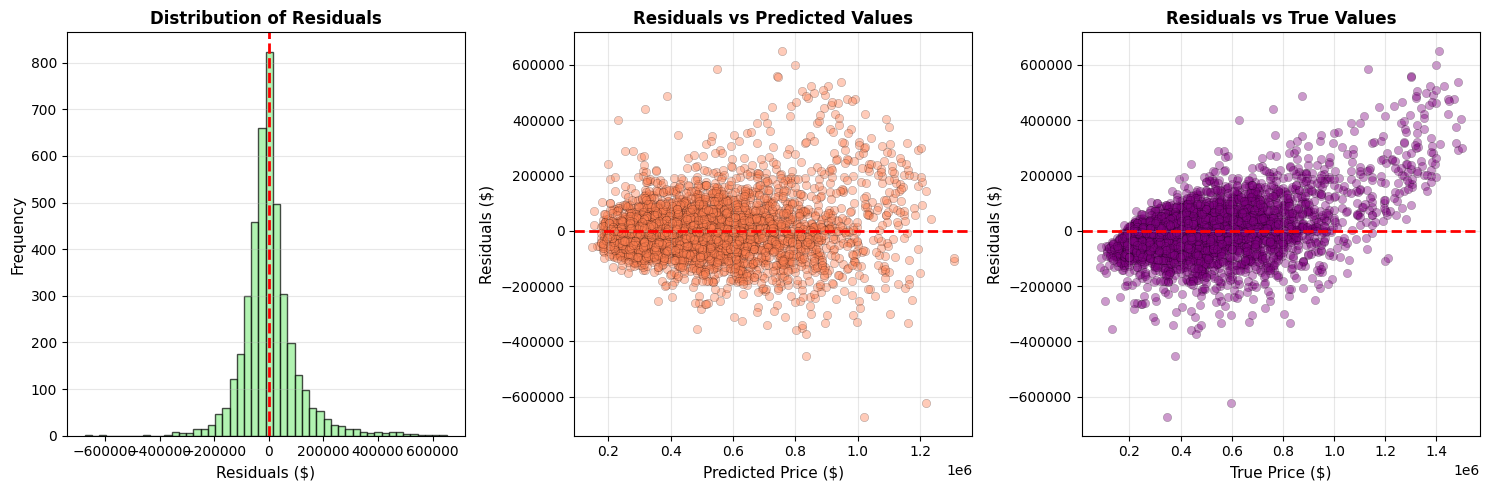


 Residual Statistics:
Mean residual:     $2438.20
Std residual:      $100977.69
Min residual:      $-674601.40
Max residual:      $651498.59


In [ ]:
# --- 8. Residual Analysis ---
residuals = y_test - y_pred_rf_best

plt.figure(figsize=(15, 5))

# 8.1 Distribution of residuals
plt.subplot(1, 3, 1)
plt.hist(residuals, bins=50, edgecolor='black', color='lightgreen', alpha=0.7)
plt.xlabel("Residuals ($)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.title("Distribution of Residuals", fontsize=12, fontweight='bold')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(axis='y', alpha=0.3)

# 8.2 Residuals vs Predictions
plt.subplot(1, 3, 2)
plt.scatter(y_pred_rf_best, residuals, alpha=0.4, color='coral', edgecolors='black', linewidth=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Price ($)", fontsize=11)
plt.ylabel("Residuals ($)", fontsize=11)
plt.title("Residuals vs Predicted Values", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 8.3 Residuals vs true price
plt.subplot(1, 3, 3)
plt.scatter(y_test, residuals, alpha=0.4, color='purple', edgecolors='black', linewidth=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("True Price ($)", fontsize=11)
plt.ylabel("Residuals ($)", fontsize=11)
plt.title("Residuals vs True Values", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary of residuals
print("\n Residual Statistics:")
print(f"Mean residual:     ${residuals.mean():.2f}")
print(f"Std residual:      ${residuals.std():.2f}")
print(f"Min residual:      ${residuals.min():.2f}")
print(f"Max residual:      ${residuals.max():.2f}")

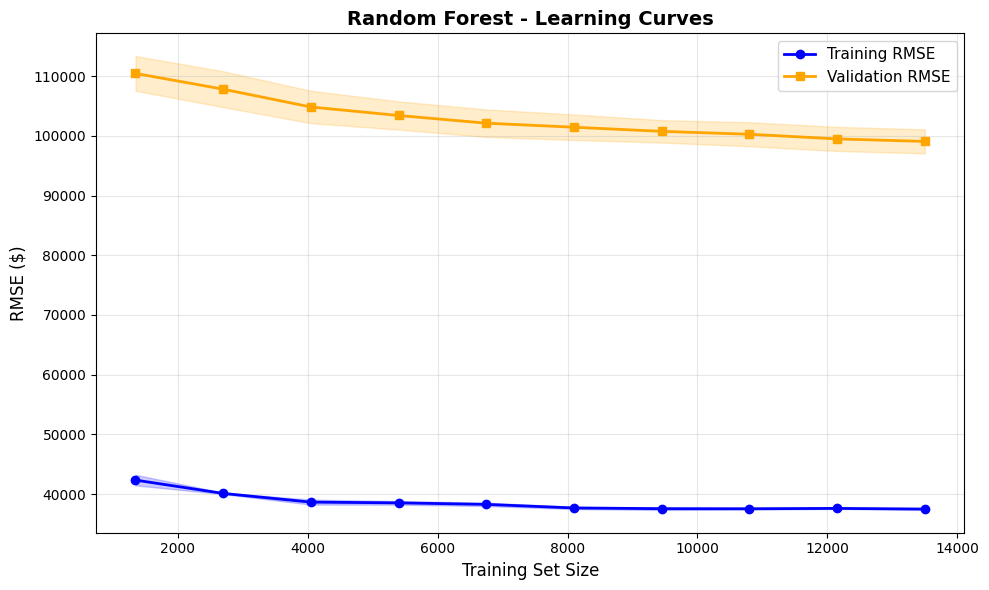

In [ ]:
# --- 9. Learning Curves ---

train_sizes, train_scores, val_scores = learning_curve(
    best_rf,
    X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    verbose=0
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training RMSE',
         marker='o', color='blue', linewidth=2)
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color='blue')

plt.plot(train_sizes, val_scores_mean, label='Validation RMSE',
         marker='s', color='orange', linewidth=2)
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.2, color='orange')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE ($)', fontsize=12)
plt.title('Random Forest - Learning Curves', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Sample of 100 predictions:
      Real price  Predicted price          Error    Error %
468     340500.0    358190.583333  -17690.583333  -5.195472
523     235000.0    260213.001667  -25213.001667 -10.728937
648     157000.0    217638.455000  -60638.455000 -38.623220
845     352000.0    384268.935000  -32268.935000  -9.167311
873     785000.0    870403.750000  -85403.750000 -10.879459
928     359000.0    361887.500000   -2887.500000  -0.804318
1081    825000.0    542956.810000  282043.190000  34.187053
1095    435000.0    440254.260000   -5254.260000  -1.207876
1138    219000.0    219460.735000    -460.735000  -0.210381
1297    389250.0    352731.875000   36518.125000   9.381663


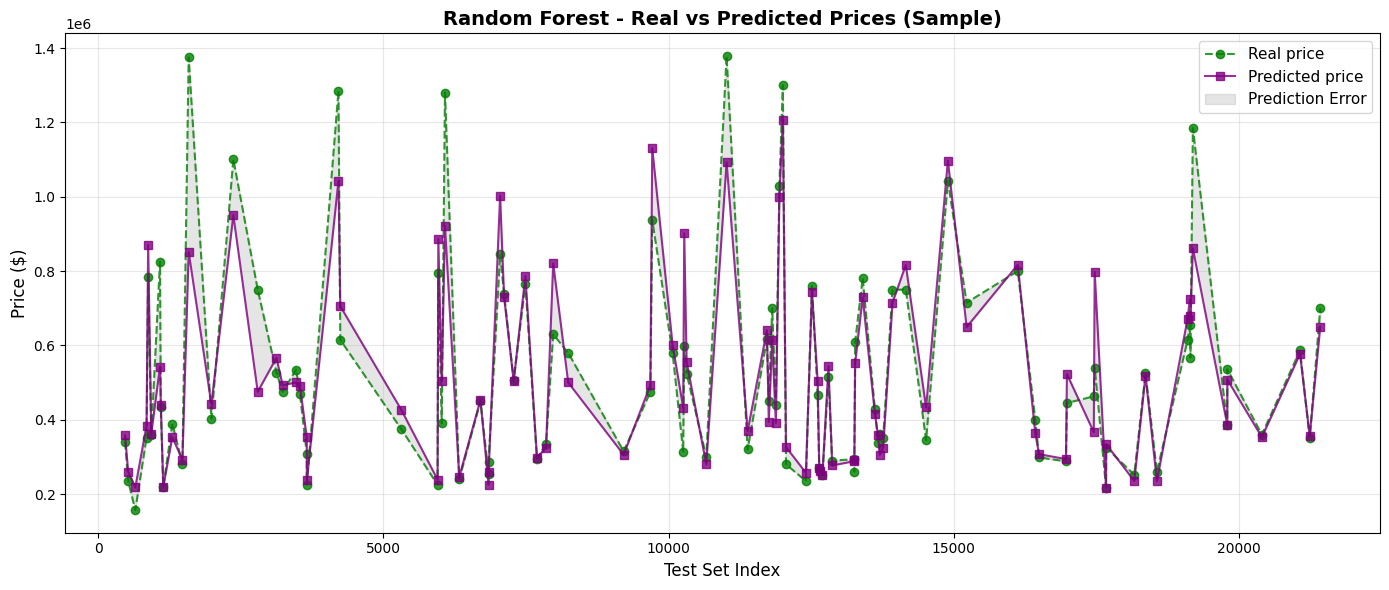

In [ ]:
# --- 10. Sample Comparison: Real vs Predicted ---
sample_size = 100
comparison = pd.DataFrame({
    "Real price": y_test,
    "Predicted price": y_pred_rf_best,
    "Error": y_test - y_pred_rf_best,
    "Error %": ((y_test - y_pred_rf_best) / y_test * 100)
}).sort_index().sample(n=sample_size, random_state=42).sort_index()

print(f"\nSample of {sample_size} predictions:")
print(comparison.head(10))

plt.figure(figsize=(14, 6))
plt.plot(comparison.index, comparison["Real price"],
         label="Real price", color="green", marker="o",
         linestyle="--", alpha=0.8, linewidth=1.5)
plt.plot(comparison.index, comparison["Predicted price"],
         label="Predicted price", color="purple", marker="s",
         linestyle="-", alpha=0.8, linewidth=1.5)

plt.fill_between(comparison.index,
                 comparison["Real price"],
                 comparison["Predicted price"],
                 alpha=0.2, color='gray', label='Prediction Error')

plt.title("Random Forest - Real vs Predicted Prices (Sample)",
          fontsize=14, fontweight='bold')
plt.xlabel("Test Set Index", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The Random Forest model achieves an R² of about 0.85, which means it explains roughly 85% of the variance in house prices in the test set. This is higher than the linear regression model, so the forest captures more of the complexity and non-linear effects in the data.

On the “Predictions vs True Values” plot, most points lie close to the red diagonal line, showing that predicted prices are generally close to the real prices. For the most expensive houses, many points are below the diagonal: the model tends to underestimate very high prices, which is typical for ensemble models that average many trees.

On the feature importance chart, three variables clearly dominate: grade, sqft_living, and med_sqft_price2015_byzip_online. This means the model mainly uses construction quality, living area, and the typical price level of the zipcode to predict the price. Other variables such as yr_built, view, sqft_lot or waterfront_num still have an effect, but they play a secondary role compared to these three main drivers.

#**Model n°6 : Stacking Ensemble**

In [ ]:

#STACKING ENSEMBLE - COMBINING MULTIPLE MODELS
#Stacking combines predictions from multiple base models")

#using a meta-learner to produce final predictions

# --- 1. Define Base Models ---
# Base model 1: Random Forest (optimized)
base_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Base model 2: XGBoost (optimized)
base_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Base model 3: Gradient Boosting (sklearn)
base_gb = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

# Base model 4: KNN (optimized)
base_knn = KNeighborsRegressor(
    n_neighbors=9,
    weights='distance',
    p=1,
    n_jobs=-1
)

# Base model 5: Decision Tree (regularized)
base_dt = DecisionTreeRegressor(
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# List of base estimators
base_estimators = [
    ('rf', base_rf),
    ('xgb', base_xgb),
    ('gb', base_gb),
    ('knn', base_knn),
    ('dt', base_dt)
]

print("Base Models defined:")
for name, model in base_estimators:
    print(f"   - {name}: {model.__class__.__name__}")

Base Models defined:
   - rf: RandomForestRegressor
   - xgb: XGBRegressor
   - gb: GradientBoostingRegressor
   - knn: KNeighborsRegressor
   - dt: DecisionTreeRegressor


In [ ]:
# --- 2. Define Meta-Learner ---

meta_learner_ridge = Ridge(alpha=10)
meta_learner_lasso = Lasso(alpha=0.001, max_iter=10000)

print("Meta-Learners to test:")
print("   - Ridge Regression (alpha=10)")
print("   - Lasso Regression (alpha=0.001)")

Meta-Learners to test:
   - Ridge Regression (alpha=10)
   - Lasso Regression (alpha=0.001)


In [ ]:
# --- 3. Build Stacking Ensemble with Ridge Meta-Learner ---

stacking_ridge = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_learner_ridge,
    cv=5,
    n_jobs=-1,
    verbose=1
)

#Training Stacking Ensemble

stacking_ridge.fit(X_train, y_train)

# Predictions
y_pred_stacking_ridge = stacking_ridge.predict(X_test)

evaluate_regression(y_test, y_pred_stacking_ridge, model_name="Stacking Ensemble - Ridge")

--- Stacking Ensemble - Ridge ---
MAE :  62397.44
MSE :  8697652238.30
RMSE: 93261.20
R²   : 0.8611



(62397.437722069335,
 8697652238.30089,
 np.float64(93261.2043579799),
 0.8611256102708649)

In [ ]:
# --- 4. Build Stacking Ensemble with Lasso Meta-Learner ---
stacking_lasso = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_learner_lasso,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Attentino : this may take 5-10 minutes
stacking_lasso.fit(X_train, y_train)

y_pred_stacking_lasso = stacking_lasso.predict(X_test)

evaluate_regression(y_test, y_pred_stacking_lasso, model_name="Stacking Ensemble - Lasso")

--- Stacking Ensemble - Lasso ---
MAE :  62397.44
MSE :  8697652238.30
RMSE: 93261.20
R²   : 0.8611



(62397.43772206753,
 8697652238.3006,
 np.float64(93261.20435797835),
 0.8611256102708695)

In [ ]:
# --- 5. Comparison of Both Stacking Models ---

# Calculate metrics for both
mae_ridge = mean_absolute_error(y_test, y_pred_stacking_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_stacking_ridge))
r2_ridge = r2_score(y_test, y_pred_stacking_ridge)

mae_lasso = mean_absolute_error(y_test, y_pred_stacking_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_stacking_lasso))
r2_lasso = r2_score(y_test, y_pred_stacking_lasso)

comparison_df = pd.DataFrame({
    'Meta-Learner': ['Ridge', 'Lasso'],
    'MAE': [mae_ridge, mae_lasso],
    'RMSE': [rmse_ridge, rmse_lasso],
    'R²': [r2_ridge, r2_lasso]
})

print("\n" + comparison_df.to_string(index=False))

# Select best model
if r2_ridge > r2_lasso:
    best_stacking = stacking_ridge
    y_pred_stacking_best = y_pred_stacking_ridge
    best_meta = "Ridge"
else:
    best_stacking = stacking_lasso
    y_pred_stacking_best = y_pred_stacking_lasso
    best_meta = "Lasso"

print(f"\n Best Meta-Learner: {best_meta} (R² = {max(r2_ridge, r2_lasso):.4f})")


Meta-Learner          MAE         RMSE       R²
       Ridge 62397.437722 93261.204358 0.861126
       Lasso 62397.437722 93261.204358 0.861126

 Best Meta-Learner: Lasso (R² = 0.8611)


In [ ]:
# --- 6. Evaluate Each Base Model Individually ---

base_model_results = []

for name, model in base_estimators:
    print(f"\nTraining {name}")

    # Train individual model
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred_base)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
    r2 = r2_score(y_test, y_pred_base)

    base_model_results.append({
        'Model': name.upper(),
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R²:   {r2:.4f}")

# Add stacking results
base_model_results.append({
    'Model': f'STACKING ({best_meta})',
    'MAE': mae_ridge if best_meta == 'Ridge' else mae_lasso,
    'RMSE': rmse_ridge if best_meta == 'Ridge' else rmse_lasso,
    'R²': r2_ridge if best_meta == 'Ridge' else r2_lasso
})

results_df = pd.DataFrame(base_model_results).sort_values('R²', ascending=False)

print("SUMMARY: ALL MODELS COMPARISON")
print("\n" + results_df.to_string(index=False))


Training rf
   MAE:  67287.48
   RMSE: 101628.37
   R²:   0.8351

Training xgb
   MAE:  62220.88
   RMSE: 93349.78
   R²:   0.8609

Training gb
   MAE:  64711.03
   RMSE: 95343.66
   R²:   0.8549

Training knn
   MAE:  111695.88
   RMSE: 159374.10
   R²:   0.5944

Training dt
   MAE:  78829.00
   RMSE: 119590.25
   R²:   0.7716
SUMMARY: ALL MODELS COMPARISON

           Model           MAE          RMSE       R²
STACKING (Lasso)  62397.437722  93261.204358 0.861126
             XGB  62220.876822  93349.775428 0.860862
              GB  64711.028346  95343.663721 0.854854
              RF  67287.484276 101628.373919 0.835089
              DT  78828.998768 119590.251069 0.771644
             KNN 111695.882383 159374.103206 0.594440


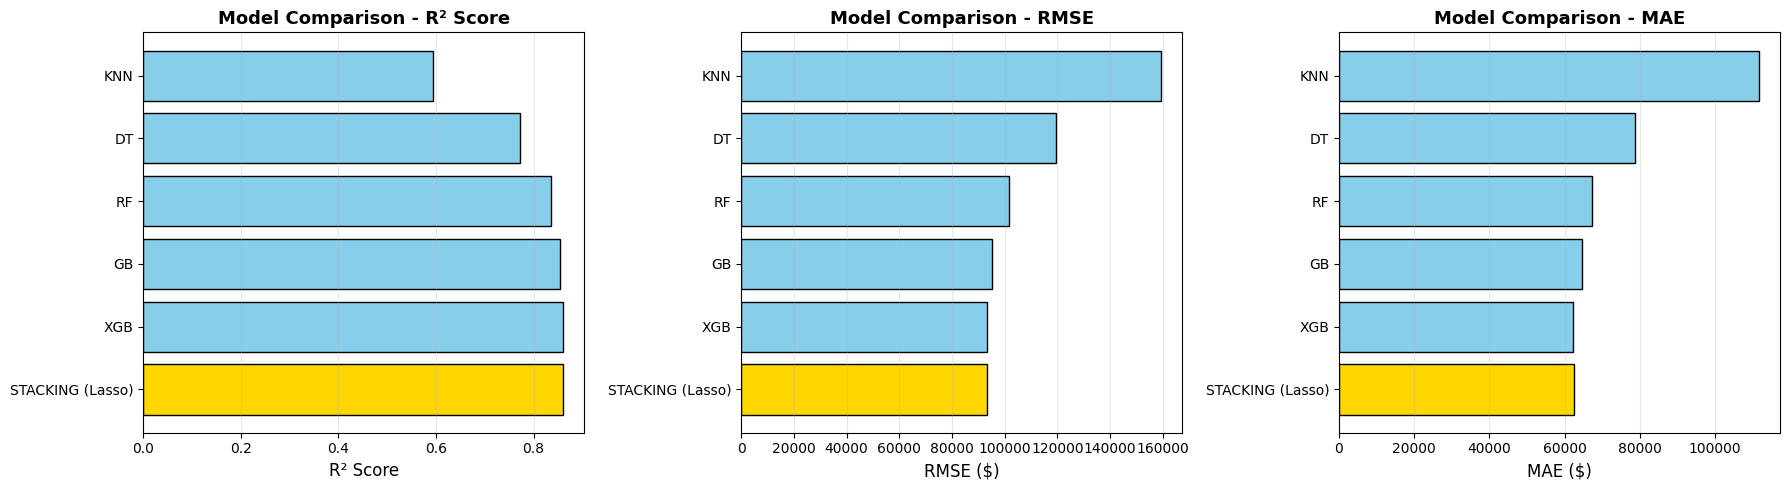

Stacking Ensemble highlights:
   - Combines 5 diverse models
   - Meta-learner: Lasso
   - Achieves R² = 0.8611


In [ ]:
# --- 7. Visualization: Model Comparison ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 7.1 R² Score Comparison
ax1 = axes[0]
colors = ['gold' if model == f'STACKING ({best_meta})' else 'skyblue'
          for model in results_df['Model']]
ax1.barh(results_df['Model'], results_df['R²'], color=colors, edgecolor='black')
ax1.set_xlabel('R² Score', fontsize=12)
ax1.set_title('Model Comparison - R² Score', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 7.2 RMSE Comparison
ax2 = axes[1]
ax2.barh(results_df['Model'], results_df['RMSE'], color=colors, edgecolor='black')
ax2.set_xlabel('RMSE ($)', fontsize=12)
ax2.set_title('Model Comparison - RMSE', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 7.3 MAE Comparison
ax3 = axes[2]
ax3.barh(results_df['Model'], results_df['MAE'], color=colors, edgecolor='black')
ax3.set_xlabel('MAE ($)', fontsize=12)
ax3.set_title('Model Comparison - MAE', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Stacking Ensemble highlights:")
print(f"   - Combines {len(base_estimators)} diverse models")
print(f"   - Meta-learner: {best_meta}")
print(f"   - Achieves R² = {max(r2_ridge, r2_lasso):.4f}")

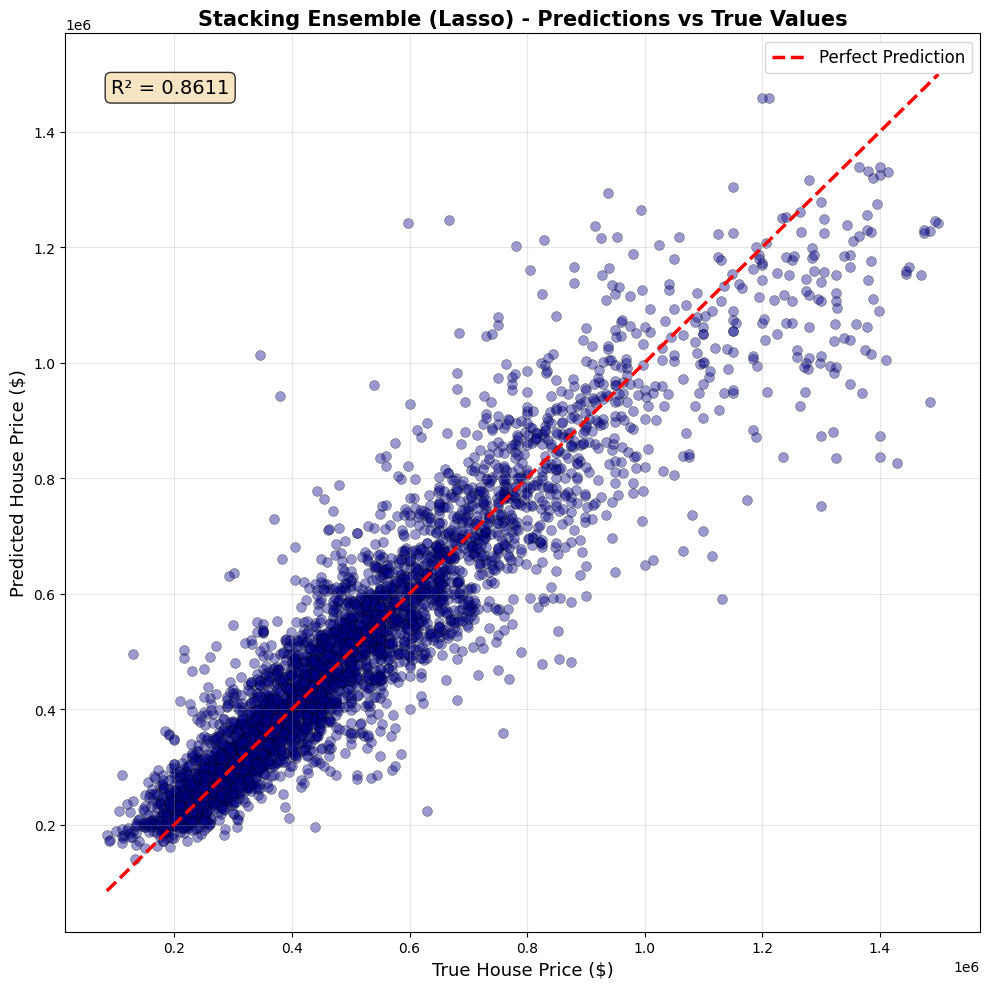

In [ ]:
# --- 8. Predictions vs True Values ---

plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(y_test, y_pred_stacking_best, alpha=0.4,
            color='darkblue', edgecolors='black', linewidth=0.5, s=50)

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2.5, label='Perfect Prediction')

# Add R² annotation
r2_best = max(r2_ridge, r2_lasso)
plt.text(0.05, 0.95, f'R² = {r2_best:.4f}',
         transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.xlabel("True House Price ($)", fontsize=13)
plt.ylabel("Predicted House Price ($)", fontsize=13)
plt.title(f"Stacking Ensemble ({best_meta}) - Predictions vs True Values",
          fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

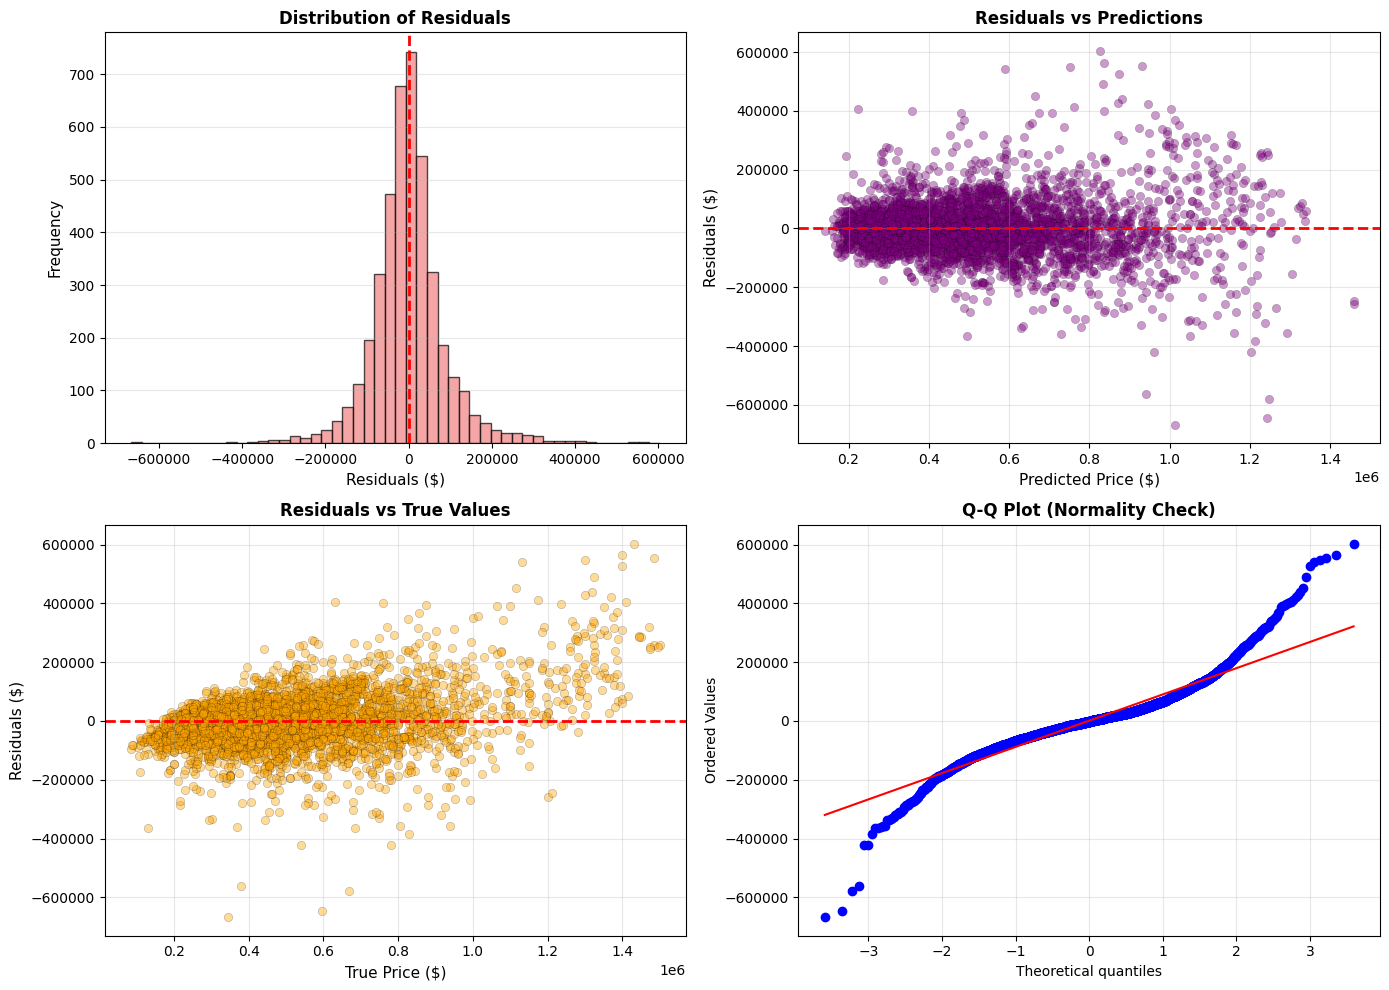


 Residual Statistics:
   Mean:     $843.48
   Std Dev:  $93268.44
   Min:      $-667133.44
   Max:      $603459.26
   Median:   $-2120.93


In [ ]:
# --- 9. Residual Analysis ---

residuals = y_test - y_pred_stacking_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 9.1 Distribution of Residuals
ax1 = axes[0, 0]
ax1.hist(residuals, bins=50, edgecolor='black', color='lightcoral', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel("Residuals ($)", fontsize=11)
ax1.set_ylabel("Frequency", fontsize=11)
ax1.set_title("Distribution of Residuals", fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 9.2 Residuals vs Predictions
ax2 = axes[0, 1]
ax2.scatter(y_pred_stacking_best, residuals, alpha=0.4,
            color='purple', edgecolors='black', linewidth=0.3)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel("Predicted Price ($)", fontsize=11)
ax2.set_ylabel("Residuals ($)", fontsize=11)
ax2.set_title("Residuals vs Predictions", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 9.3 Residuals vs True Values
ax3 = axes[1, 0]
ax3.scatter(y_test, residuals, alpha=0.4,
            color='orange', edgecolors='black', linewidth=0.3)
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel("True Price ($)", fontsize=11)
ax3.set_ylabel("Residuals ($)", fontsize=11)
ax3.set_title("Residuals vs True Values", fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 9.4 Q-Q Plot (normality check)
ax4 = axes[1, 1]
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title("Q-Q Plot (Normality Check)", fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("\n Residual Statistics:")
print(f"   Mean:     ${residuals.mean():.2f}")
print(f"   Std Dev:  ${residuals.std():.2f}")
print(f"   Min:      ${residuals.min():.2f}")
print(f"   Max:      ${residuals.max():.2f}")
print(f"   Median:   ${residuals.median():.2f}")


 Checking for Overfitting...

 Train vs Test Performance:

Metric          Train           Test            Difference     
------------------------------------------------------------
R²              0.9211          0.8611          0.0599         
RMSE            69595.05        93261.20        -23666.15      
MAE             50163.69        62397.44        -12233.74      



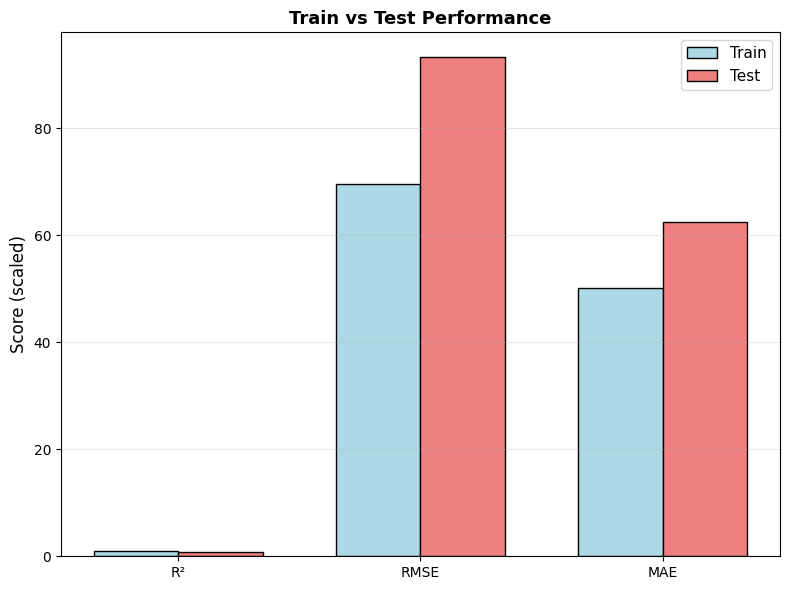

In [ ]:
# --- 10. Overfitting Check: Train vs Test Performance ---

print("\n Checking for Overfitting...")

# Predictions on training set
y_pred_train_stacking = best_stacking.predict(X_train)

# Metrics
train_r2 = r2_score(y_train, y_pred_train_stacking)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_stacking))
train_mae = mean_absolute_error(y_train, y_pred_train_stacking)

test_r2 = r2_best
test_rmse = rmse_ridge if best_meta == 'Ridge' else rmse_lasso
test_mae = mae_ridge if best_meta == 'Ridge' else mae_lasso

print("\n Train vs Test Performance:")
print(f"\n{'Metric':<15} {'Train':<15} {'Test':<15} {'Difference':<15}")
print("-" * 60)
print(f"{'R²':<15} {train_r2:<15.4f} {test_r2:<15.4f} {train_r2 - test_r2:<15.4f}")
print(f"{'RMSE':<15} {train_rmse:<15.2f} {test_rmse:<15.2f} {train_rmse - test_rmse:<15.2f}")
print(f"{'MAE':<15} {train_mae:<15.2f} {test_mae:<15.2f} {train_mae - test_mae:<15.2f}")

if train_r2 - test_r2 > 0.05:
    print("\n  Warning: Model shows signs of overfitting (R² gap > 0.05)")
else:
    print("\n Good generalization: minimal overfitting detected")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['R²', 'RMSE', 'MAE']
train_vals = [train_r2, train_rmse/1000, train_mae/1000]  # Scale for visibility
test_vals = [test_r2, test_rmse/1000, test_mae/1000]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, train_vals, width, label='Train',
               color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_vals, width, label='Test',
               color='lightcoral', edgecolor='black')

ax.set_ylabel('Score (scaled)', fontsize=12)
ax.set_title('Train vs Test Performance', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


 Sample of 100 predictions:
      Real price  Predicted price      Error ($)  Error (%)
468     340500.0     3.397484e+05     751.616057       0.22
523     235000.0     2.306851e+05    4314.868321       1.84
648     157000.0     2.037242e+05  -46724.208811     -29.76
845     352000.0     3.973266e+05  -45326.611388     -12.88
873     785000.0     8.001358e+05  -15135.818520      -1.93
928     359000.0     3.392531e+05   19746.860054       5.50
1081    825000.0     6.812906e+05  143709.430678      17.42
1095    435000.0     4.600941e+05  -25094.125480      -5.77
1138    219000.0     2.119610e+05    7039.047915       3.21
1297    389250.0     3.530849e+05   36165.145037       9.29
1474    280000.0     2.947711e+05  -14771.121245      -5.28
1584   1375000.0     1.022745e+06  352255.032000      25.62
1982    402500.0     4.101349e+05   -7634.863522      -1.90
2367   1101000.0     1.000730e+06  100270.256522       9.11
2795    750000.0     4.680029e+05  281997.059858      37.60


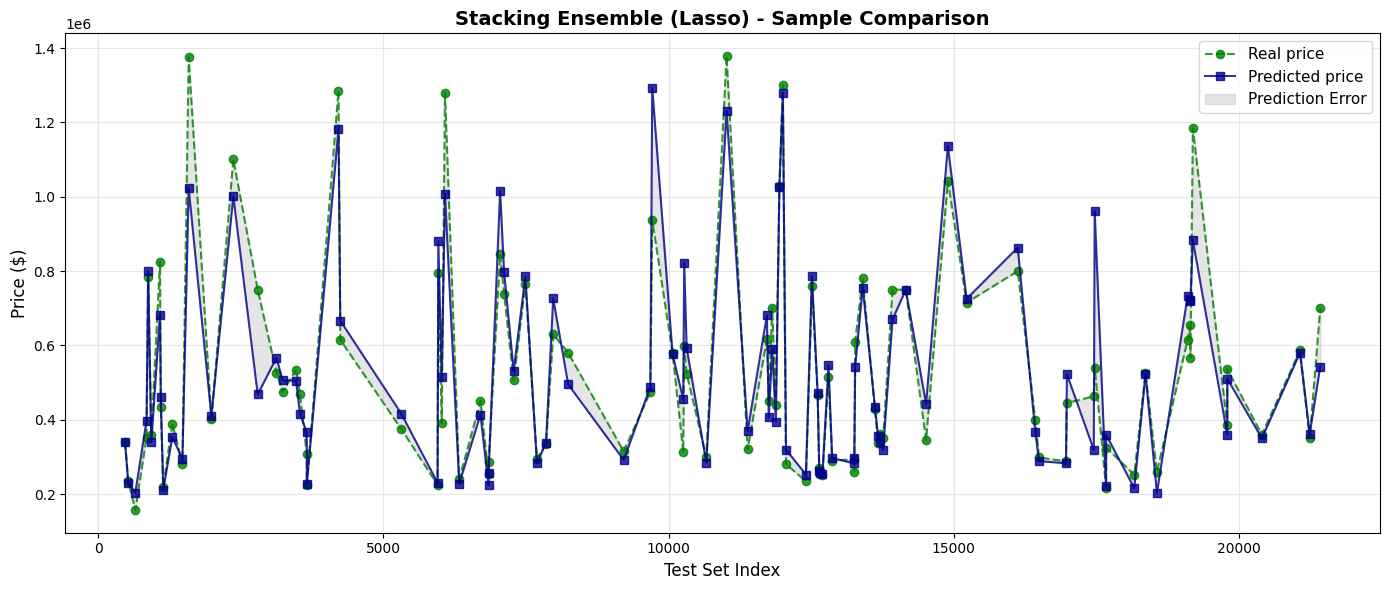

In [ ]:
# --- 11. Sample Comparison: Real vs Predicted ---

sample_size = 100

comparison_stacking = pd.DataFrame({
    "Real price": y_test,
    "Predicted price": y_pred_stacking_best,
    "Error ($)": y_test - y_pred_stacking_best,
    "Error (%)": ((y_test - y_pred_stacking_best) / y_test * 100).round(2)
}).sort_index().sample(n=sample_size, random_state=42).sort_index()

print(f"\n Sample of {sample_size} predictions:")
print(comparison_stacking.head(15).to_string(index=True))

plt.figure(figsize=(14, 6))
plt.plot(comparison_stacking.index, comparison_stacking["Real price"],
         label="Real price", color="green", marker="o",
         linestyle="--", alpha=0.8, linewidth=1.5)
plt.plot(comparison_stacking.index, comparison_stacking["Predicted price"],
         label="Predicted price", color="darkblue", marker="s",
         linestyle="-", alpha=0.8, linewidth=1.5)

plt.fill_between(comparison_stacking.index,
                 comparison_stacking["Real price"],
                 comparison_stacking["Predicted price"],
                 alpha=0.2, color='gray', label='Prediction Error')

plt.title(f"Stacking Ensemble ({best_meta}) - Sample Comparison",
          fontsize=14, fontweight='bold')
plt.xlabel("Test Set Index", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 Correlation between Base Models and Stacking Predictions:
   RF       → Stacking: 0.9884
   XGB      → Stacking: 0.9998
   GB       → Stacking: 0.9963
   KNN      → Stacking: 0.8369
   DT       → Stacking: 0.9450


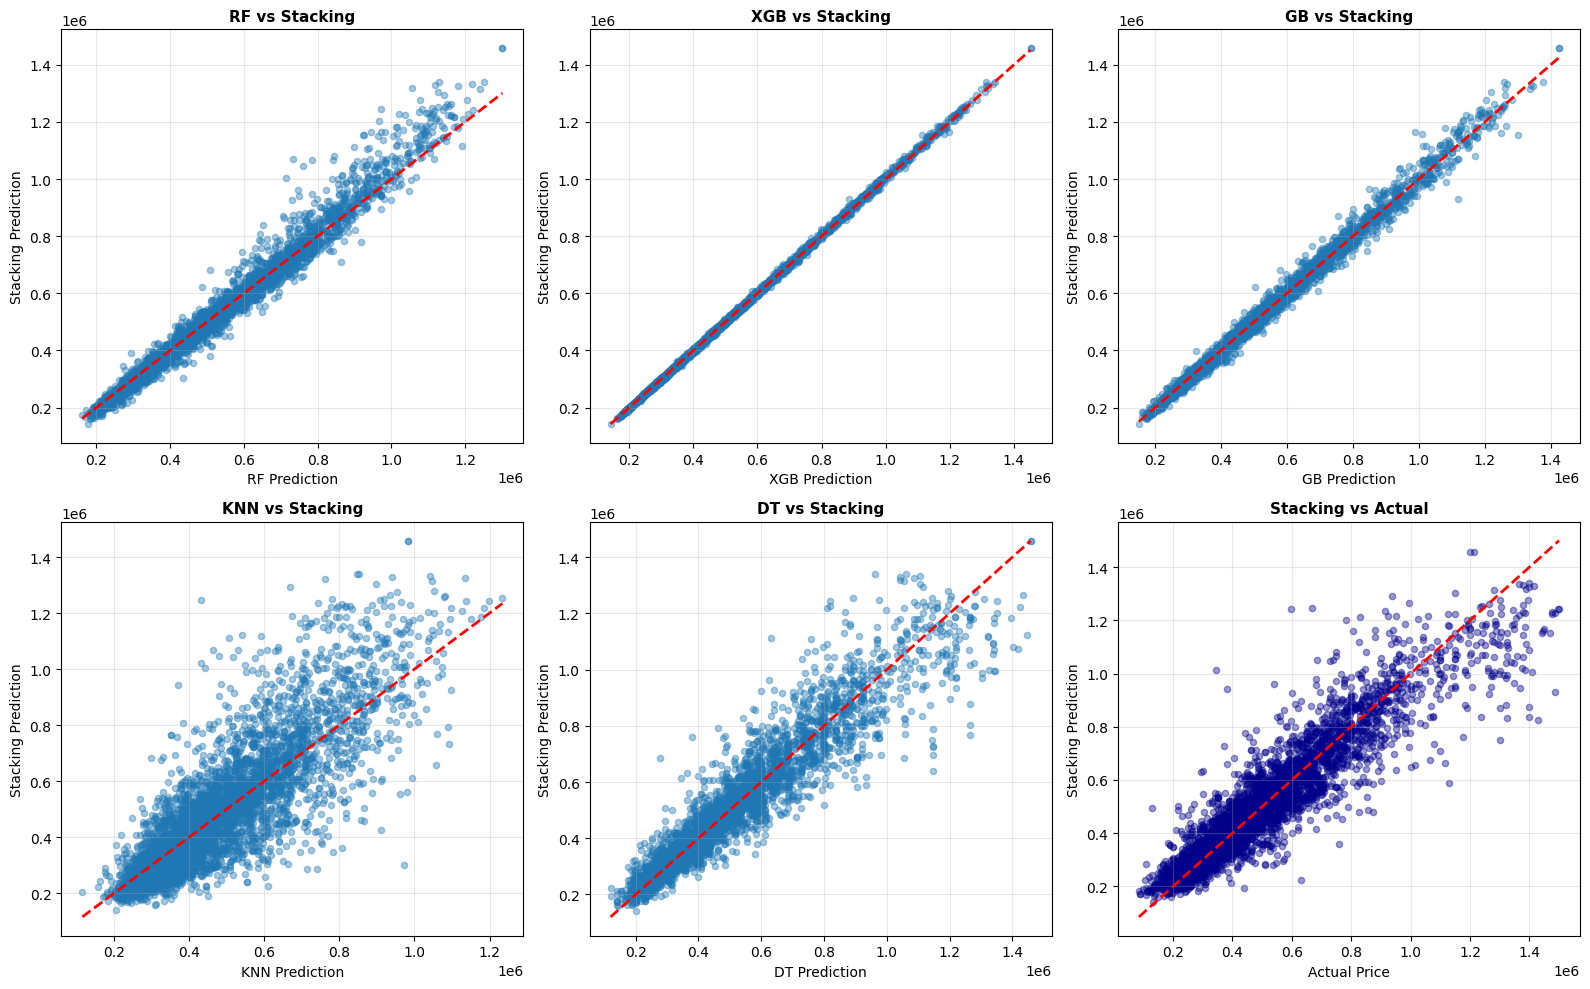

In [ ]:
# --- 12. Base Model Contribution Analysis ---

# Get predictions from each base model
base_predictions = {}

for name, model in base_estimators:
    base_predictions[name] = model.predict(X_test)

# Create DataFrame
pred_df = pd.DataFrame(base_predictions)
pred_df['Actual'] = y_test.values
pred_df['Stacking'] = y_pred_stacking_best

# Calculate correlation between each base model and stacking
print("\n Correlation between Base Models and Stacking Predictions:")
for name in pred_df.columns[:-2]:  # Exclude 'Actual' and 'Stacking'
    corr = pred_df[name].corr(pred_df['Stacking'])
    print(f"   {name.upper():<8} → Stacking: {corr:.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, name in enumerate(pred_df.columns[:-2]):
    ax = axes[idx]
    ax.scatter(pred_df[name], pred_df['Stacking'], alpha=0.4, s=20)
    ax.plot([pred_df[name].min(), pred_df[name].max()],
            [pred_df[name].min(), pred_df[name].max()],
            'r--', linewidth=2)
    ax.set_xlabel(f'{name.upper()} Prediction', fontsize=10)
    ax.set_ylabel('Stacking Prediction', fontsize=10)
    ax.set_title(f'{name.upper()} vs Stacking', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Final comparison
ax = axes[5]
ax.scatter(pred_df['Actual'], pred_df['Stacking'], alpha=0.4, s=20, color='darkblue')
ax.plot([pred_df['Actual'].min(), pred_df['Actual'].max()],
        [pred_df['Actual'].min(), pred_df['Actual'].max()],
        'r--', linewidth=2)
ax.set_xlabel('Actual Price', fontsize=10)
ax.set_ylabel('Stacking Prediction', fontsize=10)
ax.set_title('Stacking vs Actual', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --- 13. Final Summary and Recommendations ---

print(f"\n Best Configuration:")
print(f"   - Meta-Learner: {best_meta}")
print(f"   - Number of Base Models: {len(base_estimators)}")
print(f"   - Cross-Validation Folds: 5")

print(f"\n Final Performance:")
print(f"   - R² Score: {test_r2:.4f}")
print(f"   - RMSE: ${test_rmse:,.2f}")
print(f"   - MAE: ${test_mae:,.2f}")

print(f"\n Key Insights:")
print(f"   1. Stacking combines strengths of multiple models")
print(f"   2. Meta-learner learns optimal weights for base predictions")
print(f"   3. Generally achieves better performance than individual models")
print(f"   4. Reduces variance through ensemble diversity")

# Best model recommendation
best_individual = results_df.iloc[1]  # Second best after stacking
improvement = (test_r2 - best_individual['R²']) * 100

print(f"\Comparison with Best Individual Model:")
print(f"   - Best Individual: {best_individual['Model']} (R² = {best_individual['R²']:.4f})")
print(f"   - Stacking Improvement: +{improvement:.2f}% in R²")

if improvement > 1:
    print(f"    Stacking provides meaningful improvement")
else:
    print(f"     Improvement is marginal - consider computational cost")



 Best Configuration:
   - Meta-Learner: Lasso
   - Number of Base Models: 5
   - Cross-Validation Folds: 5

 Final Performance:
   - R² Score: 0.8611
   - RMSE: $93,261.20
   - MAE: $62,397.44

 Key Insights:
   1. Stacking combines strengths of multiple models
   2. Meta-learner learns optimal weights for base predictions
   3. Generally achieves better performance than individual models
   4. Reduces variance through ensemble diversity
\Comparison with Best Individual Model:
   - Best Individual: XGB (R² = 0.8609)
   - Stacking Improvement: +0.03% in R²
     Improvement is marginal - consider computational cost


<>:23: SyntaxWarning: invalid escape sequence '\C'
<>:23: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-78552400.py:23: SyntaxWarning: invalid escape sequence '\C'
  print(f"\Comparison with Best Individual Model:")


#**Model n°7 : PCA**